In [2]:
import torch; torch.manual_seed(0)
import torch.nn.functional as F
from torch.distributions import constraints

import gpytorch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import torch.utils
import torch.distributions
import torchvision
import tsfresh
import os
import copy
import json
import time
import random
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.distributions import Categorical

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'mps'

In [13]:
# import data (summary statistics as input)
with open("summary_statistics/train_summary_stat.json", "r") as file:
    training = json.load(file)
with open("summary_statistics/val_summary_stat.json", "r") as file:
    val = json.load(file)
with open("summary_statistics/test_summary_stat.json", "r") as file:
    test = json.load(file)

X, Targets, train_data = training['parameter'], training['summary_statistics'], training['data']
X_val, Targets_val, val_data = val['parameter'], val['summary_statistics'], val['data']
X_test, Targets_test, test_data = test['parameter'], test['summary_statistics'], test['data']

input_scaler = MinMaxScaler()
input_scaler.fit(X)
output_scaler = MinMaxScaler()
output_scaler.fit(Targets)
data_scaler = MinMaxScaler()
data_scaler.fit(train_data)

# X: Parameters, Target: Summary Statics, Data: Spectrum Data
X_scaled = input_scaler.transform(X)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)
Targets_scaled = output_scaler.transform(Targets)
Targets_val_scaled = output_scaler.transform(Targets_val)
Targets_test_scaled = output_scaler.transform(Targets_test)
Data_scaled = data_scaler.transform(train_data)
Data_val_scaled = data_scaler.transform(val_data)
Data_test_scaled = data_scaler.transform(test_data)

print('Total data size:', len(X)+len(X_val)+len(X_test), ', NaN in X:', np.any(np.isnan(X_scaled)), ', NaN in Target:', np.any(np.isnan(Targets_scaled))) 
print('Training data size:', X_scaled.shape, Targets_scaled.shape, Data_scaled.shape)
print('Validation data size:', X_val_scaled.shape, Targets_val_scaled.shape, Data_val_scaled.shape) 
print('Test data size:', X_test_scaled.shape, Targets_test_scaled.shape, Data_test_scaled.shape)

mdn_train_dataset = TensorDataset(torch.tensor(Targets_scaled).float(), torch.tensor(X_scaled).float())
mdn_val_dataset = TensorDataset(torch.tensor(Targets_val_scaled).float(), torch.tensor(X_val_scaled).float())
mdn_test_dataset = TensorDataset(torch.tensor(Targets_test_scaled).float(), torch.tensor(X_test_scaled).float())

mdn_train_loader = DataLoader(mdn_train_dataset, batch_size=250, shuffle=False)
mdn_val_loader = DataLoader(mdn_val_dataset, batch_size=250, shuffle=False)
mdn_test_loader = DataLoader(mdn_test_dataset, batch_size=250, shuffle=False)

Total data size: 3848 , NaN in X: False , NaN in Target: False
Training data size: (3078, 5) (3078, 10) (3078, 101)
Validation data size: (385, 5) (385, 10) (385, 101)
Test data size: (385, 5) (385, 10) (385, 101)


## Mixture Density Networks

In [6]:
# Input size is 10
class MDN1(nn.Module):
    def __init__(self, num_gaussians=9, in_features=10, out_features=5):
        super(MDN1, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians

        self.shared_layers = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.SiLU(),
            nn.Linear(100, 200),
            nn.SiLU(),
            nn.Linear(200, 300),
            nn.SiLU(),
            nn.Linear(300, 300),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(300, 150),
            nn.Tanh()
        )

        self.pi = nn.Sequential(
            nn.Linear(150, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(150, out_features * num_gaussians)
        self.mu = nn.Linear(150, out_features * num_gaussians)
        self.tanh = nn.Tanh()
    
    def forward(self, y):
        y = self.shared_layers(y)
        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [4]:
# Input size is 10
class MDN(nn.Module):
    def __init__(self, num_gaussians=9, in_features=10, out_features=5):
        super(MDN, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians

        self.shared_layers = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.SiLU(),
            nn.Linear(100, 200),
            nn.SiLU(),
            nn.Linear(200, 300),
            nn.SiLU(),
            nn.Linear(300, 300),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(300, 150),
            nn.Tanh()
        )

        self.pi = nn.Sequential(
            nn.Linear(150, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(150, out_features * num_gaussians)
        self.mu = nn.Linear(150, out_features * num_gaussians)
        self.tanh = nn.Tanh()
    
    def forward(self, y):
        y = self.shared_layers(y)
        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [7]:
class MDN2(nn.Module):
    def __init__(self, in_features=10, out_features=5, num_gaussians=9):
        super(MDN2, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians
        
        self.shared_layers2 = nn.Sequential(
            nn.Conv1d(in_features, 200, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(200, 300, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(300, 400, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.shared_layers1 = nn.Sequential(
            nn.Linear(400, 400),
            nn.Dropout(0.2),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.Dropout(0.2),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.2),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.Tanh()
        )

        self.pi = nn.Sequential(
            nn.Linear(150, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(150, out_features * num_gaussians)
        self.mu = nn.Linear(150, out_features * num_gaussians)
        self.tanh = nn.Tanh()
    
    def forward(self, y):
        y = y.reshape(y.shape[0], y.shape[1], 1)
        y = self.shared_layers2(y)
        y = y.reshape(y.shape[0], y.shape[1])
        y = self.shared_layers1(y)
        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [47]:
class MDN3(nn.Module):
    def __init__(self, in_features=10, out_features=5, num_gaussians=9):
        super(MDN3, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians
        
        # Different architecture for shared layers
        self.shared_layers2 = nn.Sequential(
            nn.Conv1d(in_features, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ELU(),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ELU(),
        )

        self.shared_layers1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ELU()
        )

        # Different activation function for pi and a different structure for sigma and mu
        self.pi = nn.Sequential(
            nn.Linear(64, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(64, out_features * num_gaussians)
        self.mu = nn.Linear(64, out_features * num_gaussians)
    
    def forward(self, y):
        y = y.reshape(y.shape[0], y.shape[1], 1)
        y = self.shared_layers2(y)
        y = y.reshape(y.shape[0], y.shape[1])
        y = self.shared_layers1(y)
        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [9]:
class MDN4(nn.Module):
    def __init__(self, in_features=10, out_features=5, num_gaussians=9):
        super(MDN4, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians
        dropout_rate = 0.3
        # LSTM layer
        self.lstm = nn.LSTM(input_size=in_features, hidden_size=128, num_layers=2, dropout=dropout_rate, batch_first=True)
        
        output_size = num_gaussians * out_features

        self.fc_layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size)
        )

        # Align the input sizes for pi, sigma, and mu layers
        self.pi = nn.Sequential(
            nn.Linear(output_size, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(output_size, out_features * num_gaussians)
        self.mu = nn.Linear(output_size, out_features * num_gaussians)
    
    def forward(self, x):
        # LSTM output
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Check the number of dimensions in lstm_out
        if lstm_out.dim() == 2:
            # If the sequence length is 1, lstm_out will have shape [batch_size, hidden_size]
            y = lstm_out
        elif lstm_out.dim() == 3:
            # Use the last output from the sequence
            y = lstm_out[:, -1, :]
        else:
            raise ValueError("Unexpected output shape from LSTM")

        # Forward through the fully connected layers

        y = self.fc_layers(y)

        # Output layers

        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y)).view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y).view(-1, self.num_gaussians, self.out_features)

        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    nn.init.zeros_(param.data)

In [10]:
class MDN5(nn.Module):
    def __init__(self, in_features=10, out_features=5, num_gaussians=9):
        super(MDN5, self).__init__()

        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.LeakyReLU(0.1)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.PReLU()

        self.fc3 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.act3 = nn.LeakyReLU(0.1)

        output_size = num_gaussians * out_features
        self.fc4 = nn.Linear(128, output_size)

        self.pi = nn.Sequential(
            nn.Linear(output_size, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(output_size, out_features * num_gaussians)
        self.mu = nn.Linear(output_size, out_features * num_gaussians)

    def forward(self, x):
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.act2(self.bn2(self.fc2(x)))
        x = self.act3(self.dropout(self.fc3(x)))
        x = self.fc4(x)

        pi = self.pi(x)
        sigma = torch.exp(self.sigma(x)).view(-1, num_gaussians, out_features)
        mu = self.mu(x).view(-1, num_gaussians, out_features)

        return pi, sigma, mu

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [117]:
class MDN6(nn.Module):
    def __init__(self, in_channels=10, num_gaussians=9, num_classes=5):
        super(MDN6, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 16, kernel_size=3, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16, 512)  # Adjust the input size accordingly
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_gaussians * num_classes)

        # Dropout layers
        self.dropout = nn.Dropout(0.5)

        self.pi = nn.Linear(num_gaussians * num_classes, num_gaussians)
        self.sigma = nn.Linear(num_gaussians * num_classes, num_gaussians * num_classes)
        self.mu = nn.Linear(num_gaussians * num_classes, num_gaussians * num_classes)

    def forward(self, x, num_gaussians=9, num_classes=5):
        # Apply convolutional layers and pooling
        x = x.unsqueeze(2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Final fully connected layer
        x = self.fc3(x)
        pi = F.softmax(self.pi(x), dim=1)  # Mixing coefficients
        sigma = torch.exp(self.sigma(x))  # Standard deviations
        mu = self.mu(x)  # Means

        # Reshaping sigma and mu to have the shape [batch_size, num_gaussians, num_classes]
        sigma = sigma.view(-1,num_gaussians, num_classes)
        mu = mu.view(-1, num_gaussians, num_classes)

        return pi, sigma, mu
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)


$y$ [batch size, input size], $x$ [batch size, output size]

$\Pi$ [batch size, number of distribution], $\sum^{K}_{k=1}\Pi_{k} = 1$, $K$ is the number of distribution

$\sigma$ [batch size, number of distribution, output size], $\mu$ [batch size, number of distribution, output size]

Probability Distribution Function: $\mathrm{p}(\boldsymbol{x} \mid \boldsymbol{y})=\sum_{\mathrm{k}=1}^{\mathrm{K}} \Pi_{\mathrm{k}} (\boldsymbol{y})\phi_{\mathrm{k}}(\boldsymbol{x}, \sigma_{k}, \mu_{k})$

$\phi(\boldsymbol{x}, \sigma_{k}, \mu_{k}) = \sum_{c}\phi_{\mathrm{k}}(\boldsymbol{x}, \sigma_{k}, \mu_{k}) = \left(\frac{1}{\sigma_k \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu_k}{\sigma_k}\right)^2}\right)^{c}$, c is the number of output feature (5 in this case)

$\operatorname{loss}(x \mid y)=-\log \left[\sum_k^K \Pi_k(\boldsymbol{y}) \phi\left(x, \sigma_k, \mu_k\right)\right]$

In [124]:
# Training
def change_model_weights(model, old_model, tl):
    index = []
    for name, para in model.named_parameters():
        if 'shared_layers' in name:
            #para.requires_grad = False
            index.append(int(name.split(".")[1]))

    # hidden layers
    for i in list(set(index)):
        model.shared_layers[i].weight.data = old_model.shared_layers[i].weight.data
        model.shared_layers[i].bias.data = old_model.shared_layers[i].bias.data

    # output layers
    model.pi[0].weight.data = torch.zeros(model.pi[0].weight.data.shape)

    model.pi[0].bias.data = torch.zeros(model.pi[0].bias.data.shape)

    c = old_model.sigma.weight.data
    if tl == 1:
        l = random.randint(0, c.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        c = torch.cat((c, old_model.sigma.weight.data[n[i]].reshape(1, 150)), dim=0)
    model.sigma.weight.data = c

    d = old_model.sigma.bias.data
    if tl == 1:
        l = random.randint(0, d.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        d = torch.cat((d, old_model.sigma.bias.data[n[i]].reshape(1)), dim=0)
    model.sigma.bias.data = d

    e = old_model.mu.weight.data
    if tl == 1:
        l = random.randint(0, e.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        e = torch.cat((e, old_model.mu.weight.data[n[i]].reshape(1, 150)), dim=0)
    model.mu.weight.data = e

    f = old_model.mu.bias.data
    if tl == 1:
        l = random.randint(0, f.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        f = torch.cat((f, old_model.mu.bias.data[n[i]].reshape(1)), dim=0)
    model.mu.bias.data = f

    return model

def gaussian_distribution(x, mu, sigma):
    target = x.unsqueeze(1).expand_as(mu)
    ret = torch.exp(-0.5 * ((target - mu) / sigma)**2) / (sigma * np.sqrt(2.0*np.pi))
    ret = torch.prod(ret, dim=2)
    return ret

def mdn_loss_fn(pi, sigma, mu, x):
    result = gaussian_distribution(x, mu+1e-5, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result+1e-5)
    return torch.mean(result)

def train_mdn(t_loader, v_loader, n_epochs, early_stop, model, old_model):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Training data loader 
    - param2: Validation data loader
    - param3: Number of training epochs
    - param4: Threshold of early stopping
    - param5: Model to be trained (Eg: MDN(num_gaussians=a), a is number of distribution)
    - param6: Previous model used for transfer learning (None / model name)

    Returns:
    A list of training loss at each epoch, trained model, best validation loss and corresponding training loss
    """
    if isinstance(model, MDN4) or isinstance(model, MDN6):
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4, amsgrad=True, eps=1e-8, betas=(0.9, 0.999))
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    early_stop_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss, best_train = 1000.0, 0
    history = dict(train=[], val=[])
    model.apply(model.init_weights)


    # Perform transfer learning if an old model is input
    if old_model is not None:
        # tl should be 1 or 2, represent initialization method
        tl = 1
        model = change_model_weights(model, old_model, tl)
    for epoch in range(1, n_epochs + 1):
        # Training
        model = model.train()
        train_losses = []
        for batch_idx, (y, x) in enumerate(t_loader):
            optimizer.zero_grad()
            pi_variable, sigma_variable, mu_variable = model(y)
            loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        if isinstance(model, MDN4) or isinstance(model, MDN6):
            old_lr = scheduler.get_last_lr()[0]  # Get the last learning rate
            scheduler.step()
            new_lr = scheduler.get_lr()[0]  # Get the current learning rate
            if new_lr != old_lr:
                print(f'Epoch {epoch}: Learning rate changed from {old_lr} to {new_lr}')

        if isinstance(model, MDN3) or isinstance(model, MDN6):
            # gradient clipping triggered when gradient explodes
            for p in model.parameters():
                if p.grad is not None:
                    if torch.any(torch.isnan(p.grad)):
                        print(f'Epoch {epoch}: Gradient exploded')
                        nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # Validation
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for batch_idx, (y, x) in enumerate(v_loader):
                pi_variable, sigma_variable, mu_variable = model(y)
                loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        train_loss = np.mean(train_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        #if epoch%10 == 0:
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_train = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        elif (val_loss-train_loss) > 0 and val_loss >= best_loss:
            if early_stop is not None:
                early_stop_counter += 1
                if early_stop_counter > early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    print(f'Best Loss {best_loss}')
    model.load_state_dict(best_model_wts)
    return history, model.eval(), best_loss, best_train

#'''
# train single model
#old_model = torch.load('models/AE_MDN/1.pth')
a = 6
# early stop: with ae:500, without ae:600

models_ = [MDN6, MDN3, MDN4, MDN5, MDN2, MDN1]

for model_class in models_:
    model_name = model_class.__name__
    print(f'Now training {model_name}')
    
    model_instance = model_class()  # Create an instance of the model
    history, trained_model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 500, 500, model_instance, None)
    
    # Save the model
    model_path = f'{model_name}.pth'
    if os.path.exists(model_path):
        os.remove(model_path)
    torch.save(trained_model, model_path)

    a += 1
#history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 500, MDN(num_gaussians=a), None)
#torch.save(model, str(a)+'.pth')
#'''
    

'''
# mixture component number from 1 to 10 without tl
t, v =[], []
folder_name = 'AE_MDNs/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for a in range(1, 11):
    print(a)
    # early stop: with ae:500, without ae:600
    history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 500, MDN(num_gaussians=a), None)
    torch.save(model, folder_name + str(a)+'.pth')
    print(bv, '\n')
    t.append(bt)    
    v.append(bv)
'''

'''
# mixture component number from 1 to 10 with tl
t1, v1 =[], []
folder_name = 'TL_MDNs/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for a in range(1, 11):
    print(a)
    
    if a == 1:
        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 500, MDN(num_gaussians=a), None)
        torch.save(model, folder_name + str(a) + '.pth')
        print(bv, '\n')
    else:
        # early stop: with ae:60, without ae:150
        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 600, 60, MDN(num_gaussians=a), model)
        torch.save(model, folder_name + str(a) + '.pth')
        print(bv, '\n')
    
    t1.append(bt)    
    v1.append(bv)
'''

Now training MDN6


/Users/johanrensfeldt/miniconda/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1: train loss 4.197539531267607 val loss 2.277525544166565
Epoch 2: train loss 2.447840690612793 val loss 1.5114229917526245
Epoch 3: train loss 1.802977415231558 val loss 1.1846668720245361
Epoch 4: train loss 1.38268139729133 val loss 0.905438631772995
Epoch 5: train loss 1.1406124371748705 val loss 0.7507940530776978
Epoch 6: train loss 0.9159208857096158 val loss 0.47722677886486053
Epoch 7: train loss 0.6966225229776822 val loss 0.17243016697466373
Epoch 8: train loss 0.5134840997365805 val loss -0.041365593671798706
Epoch 9: train loss 0.3112972090737178 val loss -0.1883232407271862
Epoch 10: train loss 0.13736286064466605 val loss -0.42037273943424225
Epoch 11: train loss 0.007942403380114298 val loss -0.41867032647132874
Epoch 12: train loss -0.0809612986810792 val loss -0.6759032309055328
Epoch 13: train loss -0.16837968290425265 val loss -0.5415171831846237
Epoch 14: train loss -0.28918559620013606 val loss -0.7321059107780457
Epoch 15: train loss -0.3422037133803734 va

KeyboardInterrupt: 

In [39]:
trained_models = []
for i in range(6, 10):
    print(i)
    model = torch.load(f'{i}.pth')
    model.eval()
    trained_models.append(model)

print(len(trained_models))

6


FileNotFoundError: [Errno 2] No such file or directory: '6.pth'

In [14]:
# Assuming num_gaussians and out_features are defined
num_gaussians = 9
out_features = 5

mdn1_ = torch.load('MDN1.pth')
mdn2_ = torch.load('MDN2.pth')
mdn3_ = torch.load('MDN3.pth')
mdn4_ = torch.load('MDN4.pth')
mdn5_ = torch.load('MDN5.pth')

# Assuming you have a batch of data
input_data = next(iter(mdn_test_loader))[0]

# Check output of MDN1
pi1, sigma1, mu1 = mdn1_(input_data)
print("MDN1 Output Shapes:", pi1.shape, sigma1.shape, mu1.shape)

print(f'MDN1 pi: {pi1[0]}')

print('------------------')

# Check output of MDN2
# Ensure input_data is reshaped if necessary for MDN2
pi2, sigma2, mu2 = mdn2_(input_data)
print("MDN2 Output Shapes:", pi2.shape, sigma2.shape, mu2.shape)

print(f'MDN2 pi: {pi2[0]}')

print('------------------')

# Check output of MDN3
pi3, sigma3, mu3 = mdn3_(input_data)
print("MDN3 Output Shapes:", pi3.shape, sigma3.shape, mu3.shape)

print(f'MDN3 pi: {pi3[0]}')

print('------------------')

# Check output of MDN4
pi4, sigma4, mu4 = mdn4_(input_data)
print("MDN4 Output Shapes:", pi4.shape, sigma4.shape, mu4.shape)

print(f'MDN4 pi: {pi4[0]}')

print('------------------')

# Check output of MDN5
pi5, sigma5, mu5 = mdn5_(input_data)
print("MDN5 Output Shapes:", pi5.shape, sigma5.shape, mu5.shape)

print(f'MDN5 pi: {pi5[0]}')




MDN1 Output Shapes: torch.Size([250, 9]) torch.Size([250, 9, 5]) torch.Size([250, 9, 5])
MDN1 pi: tensor([1.5975e-06, 4.0005e-05, 3.4200e-04, 7.3275e-03, 7.7484e-05, 9.8039e-01,
        1.1752e-02, 6.9882e-05, 6.4123e-07], grad_fn=<SelectBackward0>)
------------------
MDN2 Output Shapes: torch.Size([250, 9]) torch.Size([250, 9, 5]) torch.Size([250, 9, 5])
MDN2 pi: tensor([1.2965e-01, 3.6589e-04, 4.3405e-01, 4.0945e-02, 3.4365e-02, 1.0113e-01,
        2.0967e-01, 4.5091e-03, 4.5325e-02], grad_fn=<SelectBackward0>)
------------------
MDN3 Output Shapes: torch.Size([250, 9]) torch.Size([250, 9, 5]) torch.Size([250, 9, 5])
MDN3 pi: tensor([2.7275e-06, 5.8913e-06, 3.0864e-05, 3.4430e-02, 3.1621e-01, 4.6696e-06,
        3.2087e-06, 6.4932e-01, 1.9381e-06], grad_fn=<SelectBackward0>)
------------------
MDN4 Output Shapes: torch.Size([250, 9]) torch.Size([250, 9, 5]) torch.Size([250, 9, 5])
MDN4 pi: tensor([0.0454, 0.0030, 0.2694, 0.0636, 0.3931, 0.1230, 0.0601, 0.0200, 0.0224],
       grad_fn

In [104]:
def ensemble_predict(models, input_data):
    batch_pi, batch_sigma, batch_mu = [], [], []

    for model in models:

        pi, sigma, mu = model(input_data)
        batch_pi.append(pi)
        batch_sigma.append(sigma)
        batch_mu.append(mu)

    # Average across models

    avg_pi = torch.mean(torch.stack(batch_pi), dim=0)
    avg_sigma = torch.mean(torch.stack(batch_sigma), dim=0)
    avg_mu = torch.mean(torch.stack(batch_mu), dim=0)

    return avg_pi, avg_sigma, avg_mu



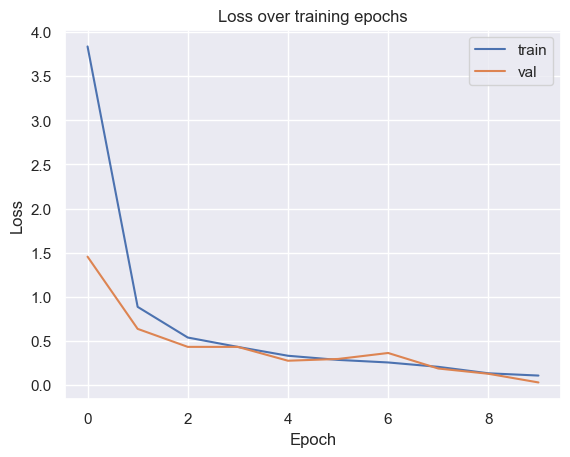

In [147]:
# Plot training loss of a single model
sns.set()
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show()

## Test with Forward Model

In [15]:
# Forward Model
class CNN(nn.Module):
    def __init__(self, input_size=5, output_size=101, num_channels1=32, num_channels2=64, kernel_size=3, dropout=0.2):
        super(CNN, self).__init__()
        self.input_size, self.output_size, self.num_channels1, self.num_channels2, self.kernel_size, self.dropout = input_size, output_size, num_channels1, num_channels2, kernel_size, dropout
        self.tcn1 = nn.Sequential(
            nn.Conv1d(input_size, 32, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn2 = nn.Sequential(    
            nn.Conv1d(32, 64, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True),
            nn.Dropout(dropout))
            
        self.f1 = nn.Linear(256, 182)
        self.f2 = nn.Linear(182, 101)
        self.silu = nn.SiLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], 1)
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = self.tcn3(x)
        x = self.tcn4(x)
        x = self.tcn5(x)
        x = x.reshape(x.shape[0], x.shape[1])
        x = self.silu(self.f1(x))
        x = self.f2(x)
        return x

Ground Truth: [0.284, 0.695, 0.542, 0.159, 0.221]
Prediction  1 : [0.229, 0.71, 0.565, 0.194, 0.092]  Mixing Coefficients: 0.968  RMSE: 0.0361
Prediction  2 : [0.156, 0.757, 0.418, 0.175, 0.084]  Mixing Coefficients: 0.029  RMSE: 0.0423
Prediction  1 : [0.229, 0.71, 0.565, 0.194, 0.092]  Mixing Coefficients: 0.968  RMSE: 0.0361
RSME: [0.03614354586809407, 0.04225473289182274, 0.78688673459655, 0.3028826393044687, 0.22825480083942284, 0.32984600254158686, 0.2869139681672627, 0.6272368879784326, 0.3467497204966749, 0] 


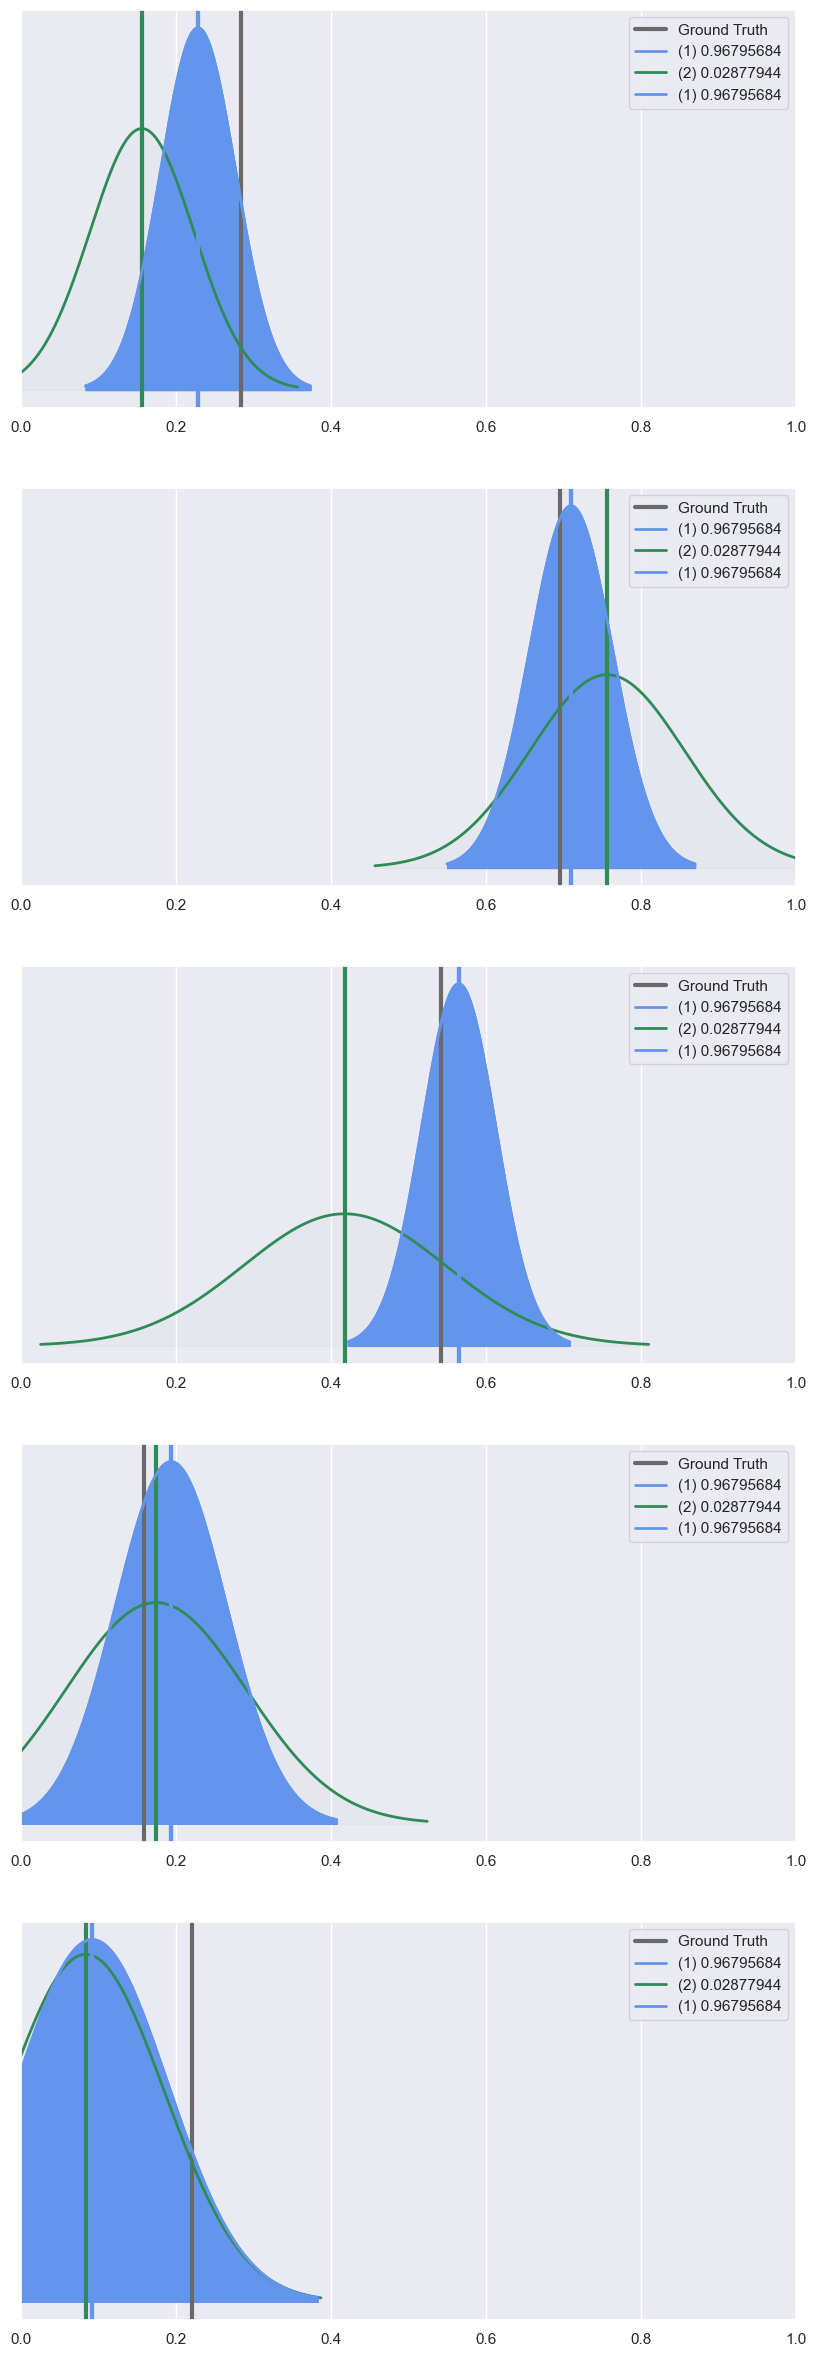

In [179]:
# Each subplot represents PDFs of each parameter
def plot_distributions(index, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    mod = torch.load('models/forward_models/cnn.pth')
    colors = ['CornflowerBlue', 'SeaGreen', 'GoldEnrod', 'IndianRed', 'DarkOrchid', 'DarkKhaki', 'PaleVioletRed', 'Chocolate', 'LightSeaGreen', 'MidnightBlue']
    #model = torch.load(path+str(num)+'.pth') 

    p, s, m, o = [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    new_p = copy.deepcopy(p[index]).tolist()
    max_number, max_index = [], []
    for _ in range(num):
        number = max(new_p)
        idx = new_p.index(number)     
        new_p[idx] = 0
        max_number.append(number)
        max_index.append(idx)

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    #original = mdn_test_dataset[index][0].tolist() 
    original = Data_test_scaled[index].tolist()
    lst, err = [], [0 for i in range(len(max_index))]
    for k in max_index:
        pre = mod(torch.from_numpy(m[index][k]).unsqueeze(0)).squeeze().tolist()
        rmse = calc_rmse(np.array(original), np.array(pre)) 
        err[k] = rmse
        # Filter out solutions that are far away from true data
        if rmse > 0.065:
            lst.append(k)
        
    sns.set()
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
    for i in range(5):
        xmin, xmax = 0, 1
        axs[i].axvline(mdn_test_dataset[index][1][i], linewidth=3, label='Ground Truth', color='DimGray')
        for j in max_index:
            if (j not in lst) or (j==max_index[0]):
                if m[index][j][i] > xmax:
                    xmax = m[index][j][i]+0.05
                if m[index][j][i] < xmin:
                    xmin = m[index][j][i]-0.05
                dist = torch.distributions.Normal(loc=torch.tensor(m[index][j][i]), scale=torch.tensor(s[index][j][i]))
                x = torch.linspace(m[index][j][i] - 3*s[index][j][i], m[index][j][i] + 3*s[index][j][i], 1000)
                pdf = torch.exp(dist.log_prob(x))
                axs[i].plot(x.numpy(), pdf.numpy(), label='('+str(j+1)+') '+str(p[index][j]), linewidth=2, color=colors[j])
                axs[i].fill_between(x.numpy(), pdf.numpy(), alpha=p[index][j], color=colors[j])
                axs[i].axvline(m[index][j][i], linewidth=3, color=colors[j])
                axs[i].axis(xmin=xmin, xmax=xmax)
                axs[i].set_yticks([])
                axs[i].legend()
                #print('m:', m[n][j][i], 's:', s[n][j][i])

    print('Ground Truth:', [round(num, 3) for num in mdn_test_dataset[index][1].tolist()])
    for j in max_index:
        if j not in lst or j==max_index[0]:
            print('Prediction ', j+1, ':', [round(num, 3) for num in m[index][j]], ' Mixing Coefficients:', round(p[index][j], 3), ' RMSE:', round(err[j], 4))

    print(f'RSME: {err} ')
    plt.show()

plot_distributions( 2, 10, 'models/AE_MDN_TL_1/')

In [19]:
def plot_distributions_ensamble(index, num, model_paths):
    """
    Plot the distribution of predictions from an ensemble of models.

    Parameters:
    - index: Index of test sample (0-384)
    - num: Number of distributions (0-10)
    - model_paths: List of paths to the models in the ensemble

    The function doesn't return anything.
    """

    # Load models
    models = [torch.load(path) for path in model_paths]

    colors = ['CornflowerBlue', 'SeaGreen', 'GoldEnrod', 'IndianRed', 'DarkOrchid', 'DarkKhaki', 'PaleVioletRed', 'Chocolate', 'LightSeaGreen', 'MidnightBlue']


    # Aggregated predictions
    p, s, m = [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        pi_agg, sigma_agg, mu_agg = [], [], []
        for model in models:
            pi_variable, sigma_variable, mu_variable = model(y)
            pi_agg.append(pi_variable.detach().numpy())
            sigma_agg.append(sigma_variable.detach().numpy())
            mu_agg.append(mu_variable.detach().numpy())
        
        # Aggregate (e.g., average) predictions from all models
        p.append(np.mean(pi_agg, axis=0))
        s.append(np.mean(sigma_agg, axis=0))
        m.append(np.mean(mu_agg, axis=0))

    print(len(p), len(s), len(m))

    # print p 
    print(f'p: {p[0]}')

    print(index)


    new_p = copy.deepcopy(p[index]).tolist()
    max_number, max_index = [], []
    for _ in range(num):
        number = max(new_p)
        idx = new_p.index(number)     
        new_p[idx] = 0
        max_number.append(number)
        max_index.append(idx)

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    #original = mdn_test_dataset[index][0].tolist() 
    original = Data_test_scaled[index].tolist()
    lst, err = [], [0 for i in range(len(max_index))]
    for k in max_index:
        for mod in models:
            pre = mod(torch.from_numpy(m[index][k]).unsqueeze(0)).squeeze().tolist()
            rmse = calc_rmse(np.array(original), np.array(pre)) 
            err[k] = rmse
            # Filter out solutions that are far away from true data
            if rmse > 0.065:
                lst.append(k)
        
    sns.set()
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
    for i in range(5):
        xmin, xmax = 0, 1
        axs[i].axvline(mdn_test_dataset[index][1][i], linewidth=3, label='Ground Truth', color='DimGray')
        for j in max_index:
            if (j not in lst) or (j==max_index[0]):
                if m[index][j][i] > xmax:
                    xmax = m[index][j][i]+0.05
                if m[index][j][i] < xmin:
                    xmin = m[index][j][i]-0.05
                dist = torch.distributions.Normal(loc=torch.tensor(m[index][j][i]), scale=torch.tensor(s[index][j][i]))
                x = torch.linspace(m[index][j][i] - 3*s[index][j][i], m[index][j][i] + 3*s[index][j][i], 1000)
                pdf = torch.exp(dist.log_prob(x))
                axs[i].plot(x.numpy(), pdf.numpy(), label='('+str(j+1)+') '+str(p[index][j]), linewidth=2, color=colors[j])
                axs[i].fill_between(x.numpy(), pdf.numpy(), alpha=p[index][j], color=colors[j])
                axs[i].axvline(m[index][j][i], linewidth=3, color=colors[j])
                axs[i].axis(xmin=xmin, xmax=xmax)
                axs[i].set_yticks([])
                axs[i].legend()
                #print('m:', m[n][j][i], 's:', s[n][j][i])

    print('Ground Truth:', [round(num, 3) for num in mdn_test_dataset[index][1].tolist()])
    for j in max_index:
        if j not in lst or j==max_index[0]:
            print('Prediction ', j+1, ':', [round(num, 3) for num in m[index][j]], ' Mixing Coefficients:', round(p[index][j], 3), ' RMSE:', round(err[j], 4))

    plt.show()

models = ['MDN1.pth', 'MDN2.pth', 'MDN3.pth', 'MDN4.pth', 'MDN5.pth']

plot_distributions_ensamble( 6, 10, models)

2 2 2
p: [[0.21617396 0.00300853 0.14077073 ... 0.05631758 0.13477862 0.03002263]
 [0.23302424 0.00663845 0.12670422 ... 0.06600805 0.16750345 0.01990866]
 [0.31360608 0.00626141 0.03088352 ... 0.03278578 0.25423223 0.09992226]
 ...
 [0.22532865 0.10664541 0.21009922 ... 0.17666736 0.16458897 0.00473187]
 [0.44035712 0.00522609 0.03833243 ... 0.05418474 0.0207996  0.09051217]
 [0.2606094  0.03488316 0.05479102 ... 0.03599633 0.11556834 0.08200051]]
6


IndexError: list index out of range

True Parameters: 
 tensor([0.4837, 0.7155, 0.6158, 0.5342, 0.3663], dtype=torch.float64)
Index: 239 , Number of Distribution: 10
tensor([0.4937, 0.7722, 0.5950, 0.5059, 0.3967])


ValueError: operands could not be broadcast together with shapes (10,) (101,) 

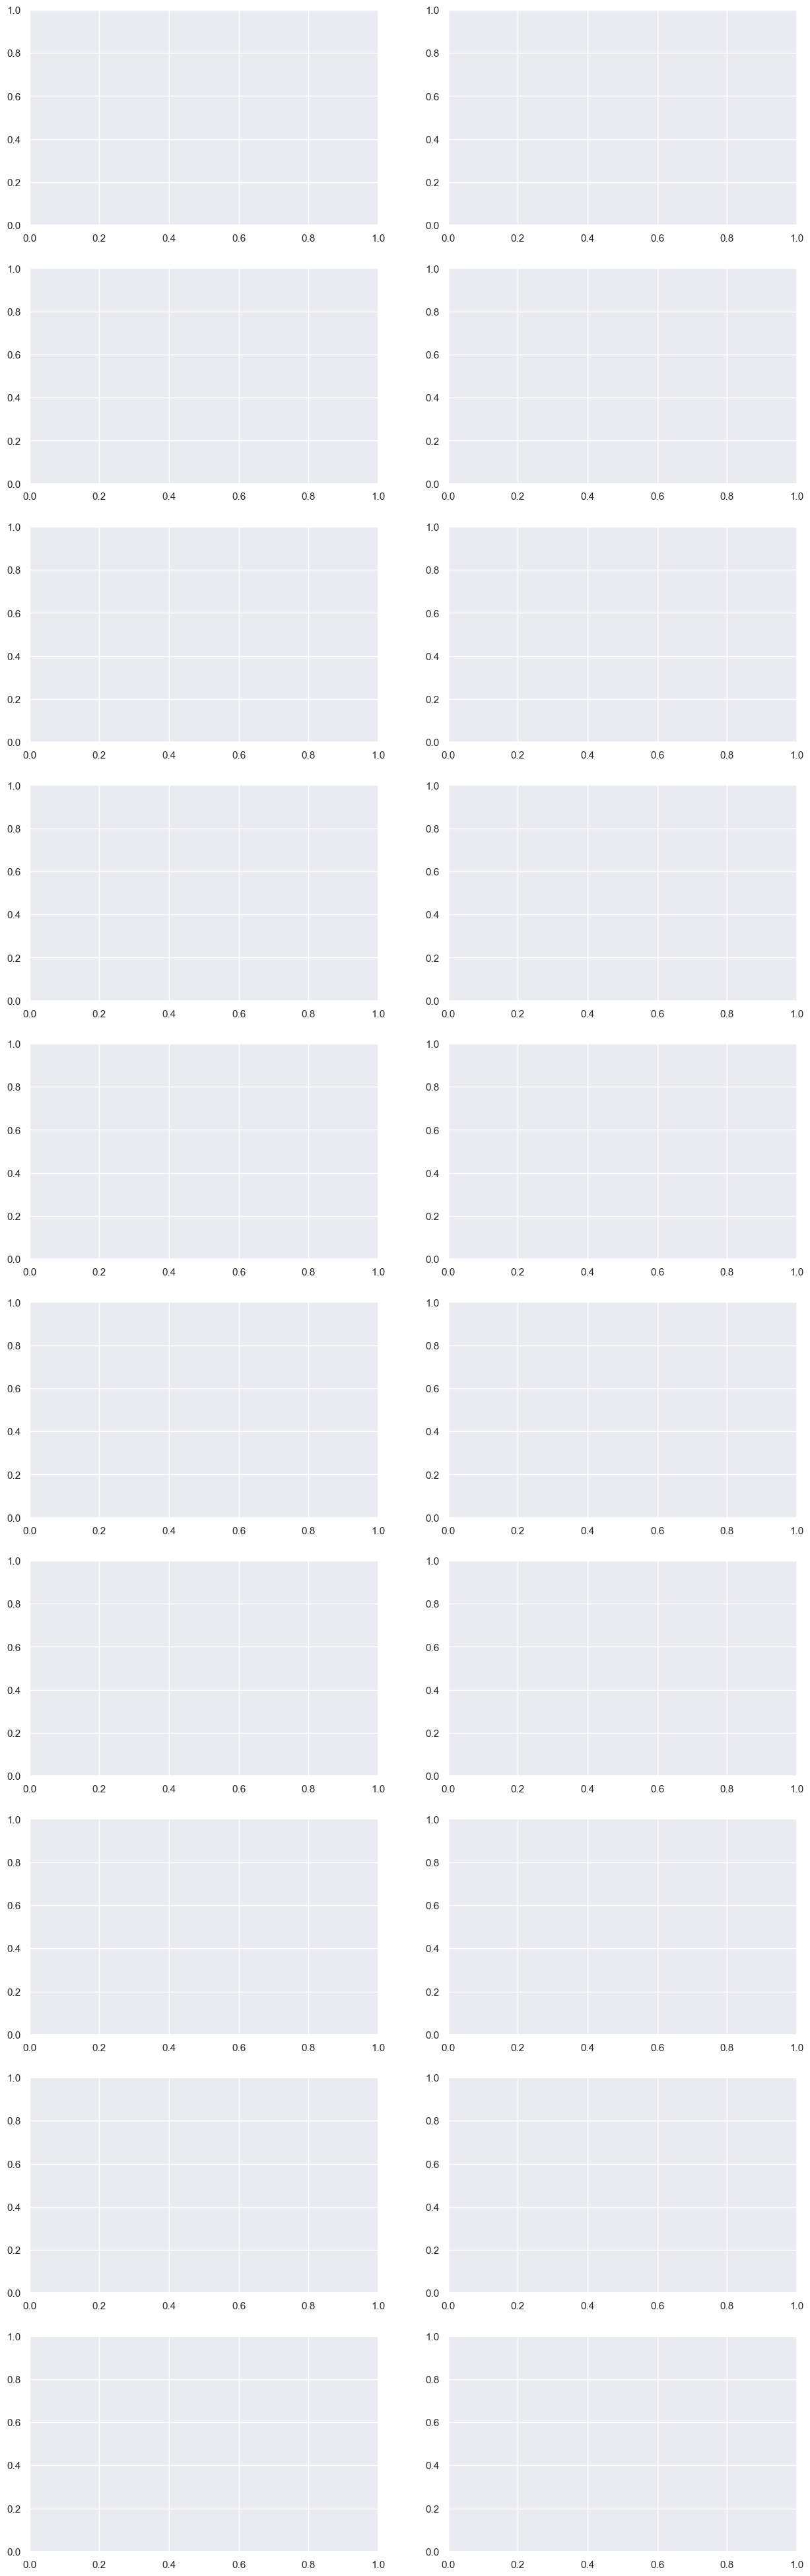

In [197]:
# Each row represents one possible solution 
def plot_one_sample(index, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """
    
    model = torch.load(path)       
    p, s, m, o, d101 = [], [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    mod = torch.load('models/forward_models/cnn.pth')
    for i in m[index]:
        pre = mod(torch.from_numpy(i).unsqueeze(0)).squeeze().tolist()
        d101.append(pre)

    if 'AE' in path:
        ori = np.array(Data_test_scaled[index])
    else:
        ori = mdn_test_dataset[index][0].detach().numpy()

    def calc_loss(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)

        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return rmse, log_mae
    
    print('True Parameters:', '\n', torch.from_numpy(X_test_scaled[index]))
    #print(torch.from_numpy(Targets_test_scaled[index]))
    print('Index:', index, ', Number of Distribution:', num)
    fig, axs = plt.subplots(nrows=num, ncols=2, figsize=(15, 5*num))
    colour = ['red', 'blue', 'green', 'orange', 'purple']
    for i in range(num):
        print(torch.from_numpy(m[index][i]))
        rmse, log_mae = calc_loss(ori, np.array(d101[i]))
        pi = p[index][i]
        axs[i, 0].set_title(f'No. {i+1},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
        axs[i, 0].plot(ori, label='Original', linewidth=3)
        axs[i, 0].plot(d101[i], label='Prediction '+str(i+1), linewidth=3)
        axs[i, 0].legend()
        axs[i, 1].set_title(f'Mixing Coefficient: {pi}')
        for j in range(5):
            dist = torch.distributions.Normal(loc=torch.tensor(m[index][i][j]), scale=torch.tensor(s[index][i][j]))
            x = torch.linspace(m[index][i][j] - 3*s[index][i][j], m[index][i][j] + 3*s[index][i][j], 1000)
            pdf = torch.exp(dist.log_prob(x))
            axs[i, 1].plot(x.numpy(), pdf.numpy(), linewidth=2, color=colour[j])
            axs[i, 1].fill_between(x.numpy(), pdf.numpy(), alpha=pi, color=colour[j])
            axs[i, 1].axvline(mdn_test_dataset[index][1][j], linewidth=3, color=colour[j])

    plt.show()

plot_one_sample(239, 10, 'MDN1.pth')

101
101
101
101
101
101
101
101
101
101
101
101
101


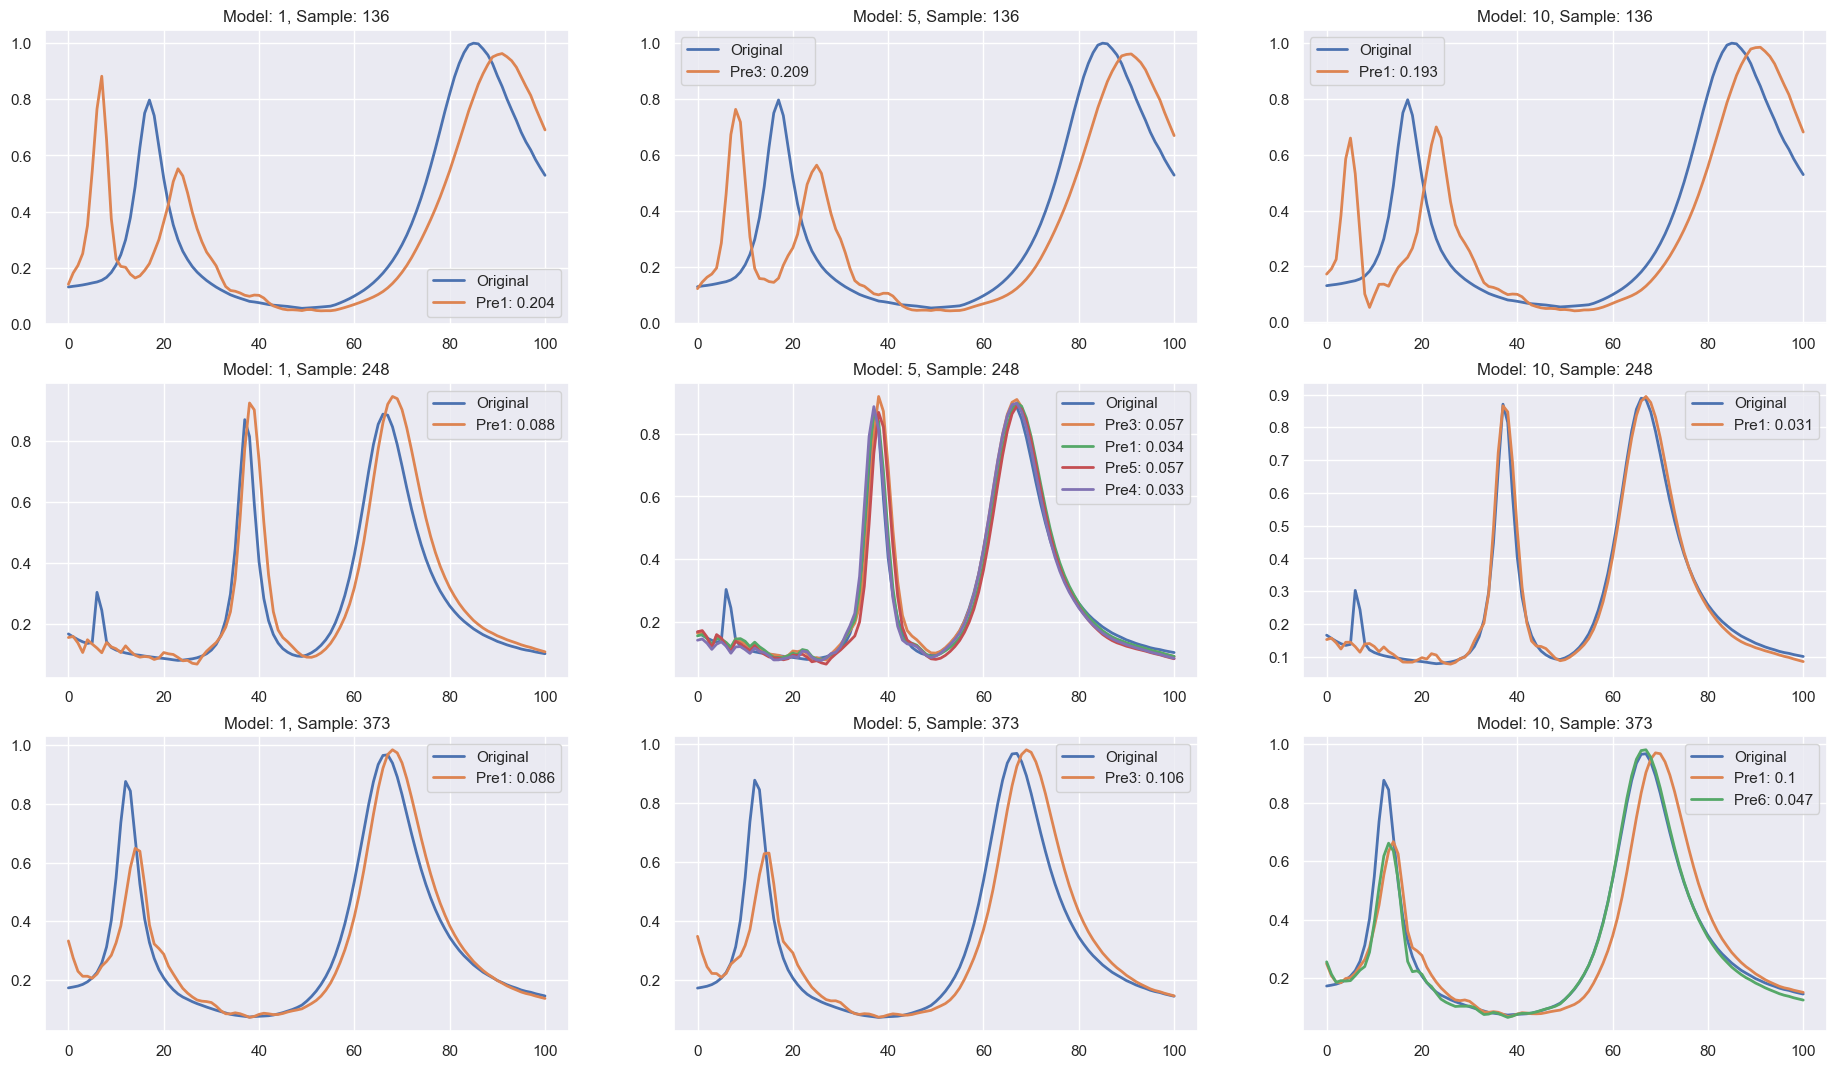

In [193]:
# Plot three test samples for model 1, 5, 10
def plot_3(samples, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains three index of test sample (0-384, Eg: [138, 248, 373])
    - param2: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """
    mod = torch.load('models/forward_models/cnn.pth')
    p, s, m, A = [], [], [], False 
    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(23, 13))
    for i in range(3):
        '''
        print('Sample:', samples[i], ', True Parameters:', mdn_test_dataset[samples[i]][1])
        if A is False:
            print('Sample:', samples[i], ', True Data:', mdn_test_dataset[samples[i]][0])
        else:
            print('Sample:', samples[i], ', True Data:', data_test_scaled[samples[i]])
        '''
        for j in range(3):
            if i == 0: 
                model_num, l = 1, 1
            elif i == 1: 
                model_num, l = 5, 5
            elif i == 2: 
                model_num, l = 10, 10

            model = torch.load(path + str(model_num) + '.pth')

            pi_variable, sigma_variable, mu_variable = model(mdn_test_dataset[samples[j]][0].unsqueeze(0))
            for z in range(len(pi_variable[0])):
                p.append(pi_variable[0][z].detach().numpy())
                s.append(sigma_variable[0][z].detach().numpy())
                m.append(mu_variable[0][z].detach().numpy())

            new_p = copy.deepcopy(p)
            max_number, max_index = [], []
            for _ in range(l):
                number = max(new_p)
                index = new_p.index(number)     
                new_p[index] = 0
                max_number.append(number)
                max_index.append(index)

            def calc_rmse(actual, predict): 
                squared_diff = (actual - predict) ** 2
                mse = squared_diff.mean()
                rmse = np.sqrt(mse)
                return rmse

            axs[j, i].set_title(f'Model: {model_num}, Sample: {samples[j]}')
            original = Data_test_scaled[samples[j]].tolist()
            axs[j, i].plot(original, label='Original', linewidth=2)
            for k in max_index:
                pre = mod(torch.from_numpy(m[k]).unsqueeze(0)).squeeze().tolist()
                # print the size of predicted data
                rmse = calc_rmse(np.array(original), np.array(pre))
                if (rmse < 0.06 and np.all(m[k] > 0)) or k == max_index[0]:
                    print(len(pre))
                    axs[j, i].plot(pre, label='Pre'+str(k+1)+': '+str(round(rmse, 3)), linewidth=2)
                    #print('Model:', model_num, ', Sample:', samples[j], ', Predicted Parameters '+str(k+1)+':', torch.from_numpy(m[k]))
                    #print('Model:', model_num, ', Sample:', samples[j], ', Predicted Data '+str(k+1)+':', torch.tensor(pre))

            axs[j, i].legend()
            p, s, m = [], [], []

    plt.show()

plot_3([136, 248, 373], 'models/AE_MDN_TL_1/')

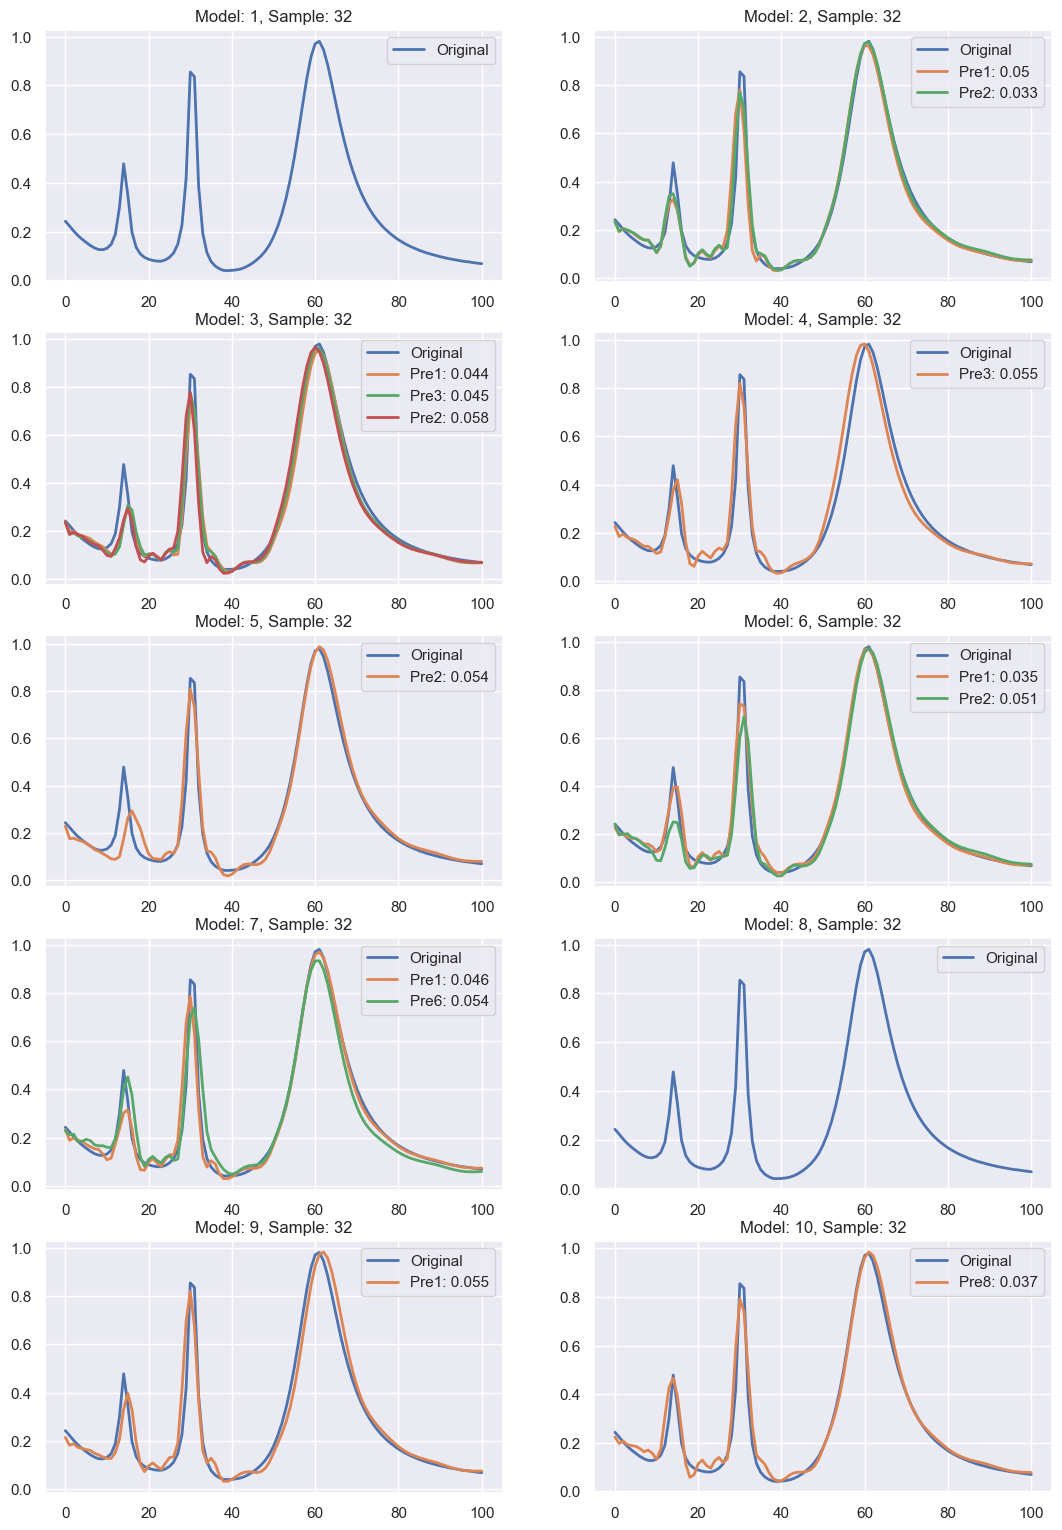

In [194]:
# One sample for all models
def plot_all_models(index, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains three index of test sample (0-384, Eg: [138, 248, 373])
    - param2: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    mod = torch.load('models/forward_models/cnn.pth')
    samples = index
    p, s, m, = [], [], [] 
    sns.set()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(13, 19))
    for i in range(5):
        for j in range(2):
            model_num = i*2+j+1
            model = torch.load(path + str(model_num) + '.pth')

            pi_variable, sigma_variable, mu_variable = model(mdn_test_dataset[samples][0].unsqueeze(0))
            for z in range(len(pi_variable[0])):
                p.append(pi_variable[0][z].detach().numpy())
                s.append(sigma_variable[0][z].detach().numpy())
                m.append(mu_variable[0][z].detach().numpy())

            new_p = copy.deepcopy(p)
            max_number, max_index = [], []
            l = model_num    
            for _ in range(l):
                number = max(new_p)
                index = new_p.index(number)     
                new_p[index] = 0
                max_number.append(number)
                max_index.append(index)

            def calc_rmse(actual, predict): 
                squared_diff = (actual - predict) ** 2
                mse = squared_diff.mean()
                rmse = np.sqrt(mse)
                return rmse

            axs[i, j].set_title(f'Model: {model_num}, Sample: {samples}')
            original = Data_test_scaled[samples].tolist()
            axs[i, j].plot(original, label='Original', linewidth=2)
            for k in max_index:
                pre = mod(torch.from_numpy(m[k]).unsqueeze(0)).squeeze().tolist()
                rmse = calc_rmse(np.array(original), np.array(pre))
                if rmse < 0.06:
                    axs[i, j].plot(pre, label='Pre'+str(k+1)+': '+str(round(rmse, 3)), linewidth=2)
            axs[i, j].legend()
            p, s, m = [], [], []

    plt.show()

plot_all_models(32, 'models/AE_MDN_TL_1/')

In [ ]:
def ensemble_predict(models, input_data):
    batch_pi, batch_sigma, batch_mu = [], [], []

    for model in models:

        pi, sigma, mu = model(input_data)
        batch_pi.append(pi)
        batch_sigma.append(sigma)
        batch_mu.append(mu)

    # Average across models

    avg_pi = torch.mean(torch.stack(batch_pi), dim=0)
    avg_sigma = torch.mean(torch.stack(batch_sigma), dim=0)
    avg_mu = torch.mean(torch.stack(batch_mu), dim=0)

    return avg_pi, avg_sigma, avg_mu

Number of Distribution: 10 , RMSE: 0.09752521245239303 , Mean Log MAE: -1.3360415878532006


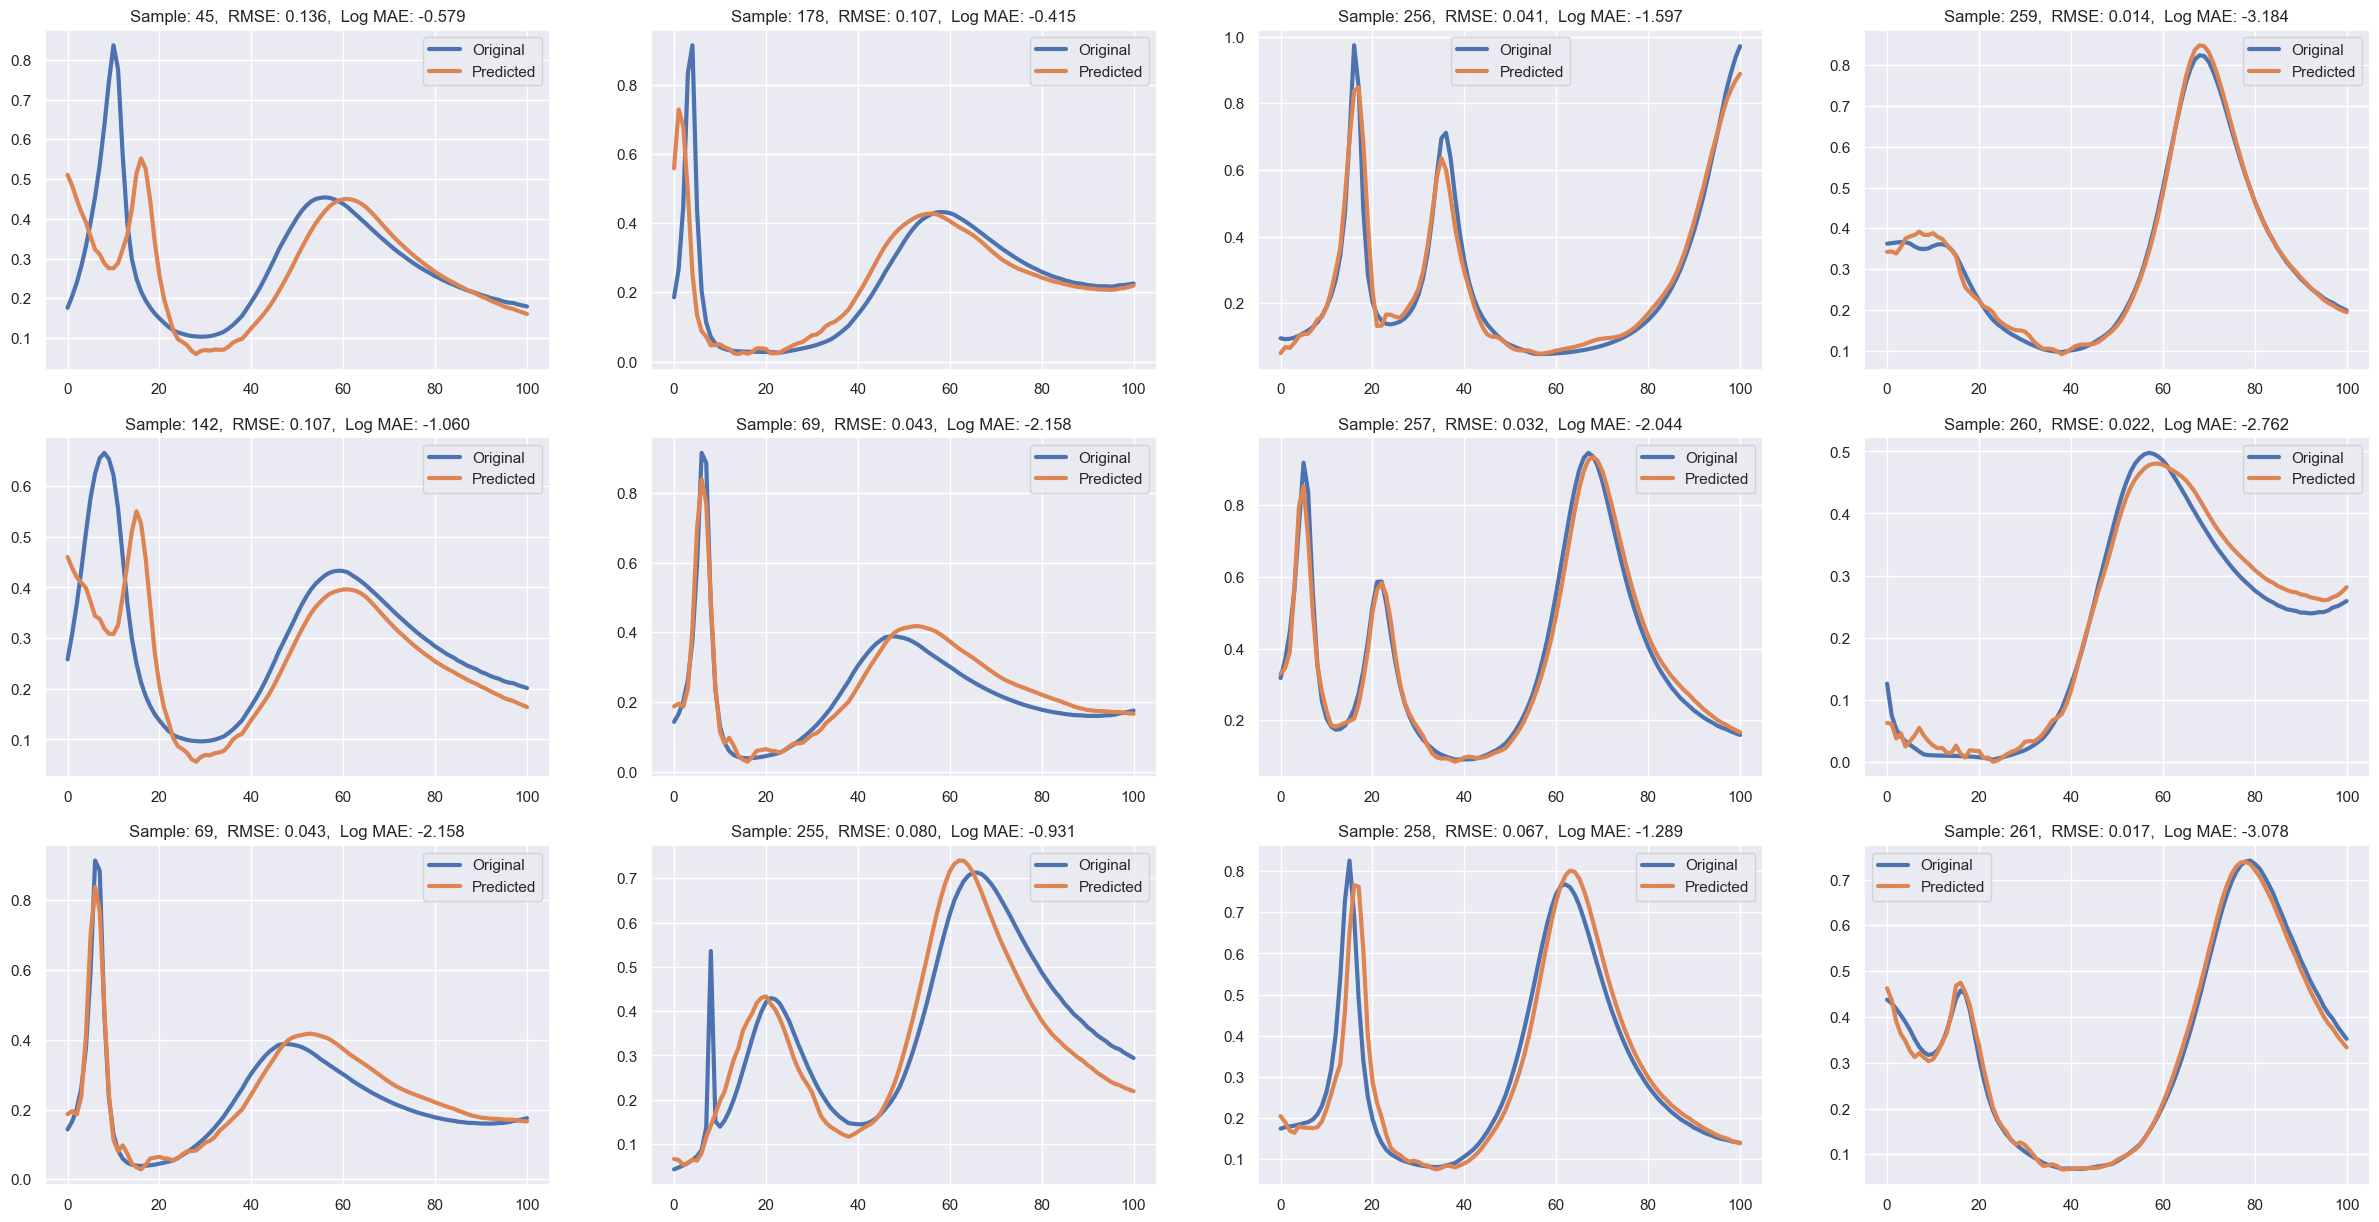

In [236]:
# Plot multiple samples using the same model
def plot_samples(l, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains ten index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """
    
    #model = torch.load(path+str(num)+'.pth')
      
    model = torch.load('MDN5.pth')    
    p, s, m, o = [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    d5, d101 = [], []
    mod = torch.load('models/forward_models/cnn.pth')
    for i in range(len(m)):
        j = list(p[i]).index(max(list(p[i])))
        d5.append(list(m[i][j]))
        pre = mod(torch.from_numpy(m[i][j]).unsqueeze(0)).squeeze().tolist()
        d101.append(pre)
        
    ori = []
    for i in Data_test_scaled:
        ori.append(np.array(i))

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    def calc_log_mae(actual, predict):
        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return log_mae

    rmse = calc_rmse(np.array(ori), np.array(d101))
    log_mae = []
    for i in range(len(d101)):
        log_mae.append(calc_log_mae(ori[i], np.array(d101)[i]))
    print('Number of Distribution:', num, ', RMSE:', rmse, ', Mean Log MAE:', np.mean(log_mae))

    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    n = 0
    for i in range(4):
        for j in range(3):
            rmse = calc_rmse(ori[l[n]], np.array(d101)[l[n]])
            log_mae = calc_log_mae(ori[l[n]], np.array(d101)[l[n]])
            axs[j, i].set_title(f'Sample: {l[n]},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
            axs[j, i].plot(ori[l[n]], label='Original', linewidth=3)
            axs[j, i].plot(np.array(d101)[l[n]], label='Predicted', linewidth=3)
            axs[j, i].legend()
            n += 1

    plt.show()

l = [45, 142, 69, 178, 69, 255, 256, 257, 258, 259, 260, 261]
plot_samples(l, 10, 'models/AE_MDN_TL_1/')

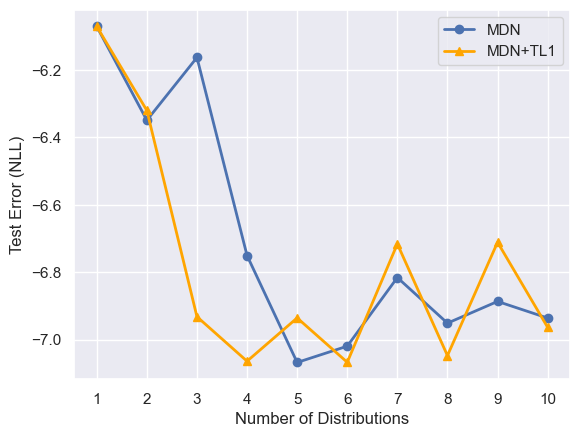

In [14]:
# Plot test nll
def gaussian_distribution(x, mu, sigma):
    target = x.unsqueeze(1).expand_as(mu)
    ret = torch.exp(-0.5 * ((target - mu) / sigma)**2) / (sigma * np.sqrt(2.0*np.pi))
    ret = torch.prod(ret, dim=2)
    return ret

def mdn_loss_fn(pi, sigma, mu, x):
    result = gaussian_distribution(x, mu+1e-5, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result+1e-5)
    return torch.mean(result)

def test_nll(path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Folder path of models used for test

    Returns:
    The function returns a list that contains test error (NLL) of each model
    """
    test_error = []
    for num in range(1, 11):
        model = torch.load(path+str(num)+'.pth')
        err = []
        for batch_idx, (y, x) in enumerate(mdn_test_loader):
            pi_variable, sigma_variable, mu_variable = model(y)
            loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
            err.append(loss.item())
        test_error.append(np.mean(err))

    return test_error

MDN_tl_err = test_nll('models/AE_MDN_TL_1/')
MDN_err = test_nll('models/AE_MDN/')

ax = plt.figure().gca()
x_values = list(np.arange(1, 11))
ax.plot(MDN_err, 'o-', linewidth=2, color='b', label='MDN')
ax.plot(MDN_tl_err, '^-', linewidth=2, color='orange', label='MDN+TL1')
ax.set_ylabel('Test Error (NLL)')
ax.set_xlabel('Number of Distributions')
ax.set_xticks(np.arange(len(x_values)))
ax.set_xticklabels(x_values)
ax.legend()
plt.show()

In [196]:
def test_rmse_ensemble(models, loader):
    all_predictions, all_true = [], []

    for inputs, true_values in loader:
        pi, sigma, mu = ensemble_predict(models, inputs)
        
        # Adjust the shape of pi to match mu for weighted sum
        pi_expanded = pi.unsqueeze(2)  # Expand pi to have the same number of dimensions as mu
        weighted_mu = pi_expanded * mu  # Element-wise multiplication
        predictions = torch.sum(weighted_mu, dim=1)  # Sum over the Gaussian components

        all_predictions.append(predictions.detach().numpy())
        all_true.append(true_values.numpy())

    # Flatten the lists
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_true = np.concatenate(all_true, axis=0)

    print(all_predictions.shape, all_true.shape)

    # Calculate RMSE
    mse = np.mean((all_true - all_predictions) ** 2)
    rmse = np.sqrt(mse)

    return rmse

# Example usage

# load models
mdn1 = torch.load('MDN1.pth')
mdn2 = torch.load('MDN2.pth')
mdn3 = torch.load('MDN3.pth')
mdn4 = torch.load('MDN4.pth')
mdn5 = torch.load('MDN5.pth')

MDNs = [mdn1, mdn2, mdn3, mdn4, mdn5]

MDN_ensemble_rmse = test_rmse_ensemble(MDNs, mdn_test_loader)
print("Ensemble Model RMSE:", MDN_ensemble_rmse)

# Plot the distribution of predictions from an ensemble of models.

# Load models

models = [torch.load(path) for path in ['MDN1.pth', 'MDN2.pth', 'MDN3.pth', 'MDN4.pth', 'MDN5.pth']]

colors = ['CornflowerBlue', 'SeaGreen', 'GoldEnrod', 'IndianRed', 'DarkOrchid', 'DarkKhaki', 'PaleVioletRed', 'Chocolate', 'LightSeaGreen', 'MidnightBlue']


# Aggregated predictions
p, s, m = [], [], []
for batch_idx, (y, x) in enumerate(mdn_test_loader):
    pi_agg, sigma_agg, mu_agg = [], [], []
    for model in models:
        pi_variable, sigma_variable, mu_variable = model(y)
        pi_agg.append(pi_variable.detach().numpy())
        sigma_agg.append(sigma_variable.detach().numpy())
        mu_agg.append(mu_variable.detach().numpy())
    
    # Aggregate (e.g., average) predictions from all models
    p.append(np.mean(pi_agg, axis=0))
    s.append(np.mean(sigma_agg, axis=0))
    m.append(np.mean(mu_agg, axis=0))

print(p[0].shape, s[0].shape, m[0].shape)

tensor([[9.0582e-01, 1.1638e-02, 1.7193e-05,  ..., 1.9000e-05, 3.5361e-05,
         8.2415e-02],
        [9.7193e-01, 9.7915e-03, 1.5779e-05,  ..., 2.1308e-05, 4.3434e-05,
         1.8116e-02],
        [9.6796e-01, 2.8779e-02, 8.4144e-05,  ..., 4.6585e-05, 4.6362e-05,
         2.8600e-03],
        ...,
        [9.9641e-01, 1.3004e-03, 7.7533e-06,  ..., 9.4355e-06, 1.2823e-05,
         2.2281e-03],
        [9.7499e-01, 2.4011e-02, 5.0090e-05,  ..., 7.2776e-05, 4.9621e-05,
         6.5884e-04],
        [9.8791e-01, 1.0760e-02, 1.6698e-05,  ..., 1.2952e-05, 1.2060e-05,
         1.2415e-03]], grad_fn=<SoftmaxBackward0>)
tensor([[[0.0431, 0.0623, 0.0557, 0.0457, 0.0478],
         [0.0449, 0.1072, 0.0613, 0.0976, 0.0889],
         [1.0672, 1.0185, 0.6763, 0.6941, 1.0569],
         ...,
         [0.7391, 0.3836, 0.3870, 0.5151, 0.5111],
         [0.5176, 0.8108, 0.8730, 0.8106, 1.3599],
         [0.0612, 0.0770, 0.0640, 0.0404, 0.0688]],

        [[0.0542, 0.0703, 0.0802, 0.0494, 0.0469],
   

tensor([[9.0582e-01, 1.1638e-02, 1.7193e-05, 1.8757e-05, 1.2938e-05, 2.4772e-05,
         1.9000e-05, 3.5361e-05, 8.2415e-02]], grad_fn=<SoftmaxBackward0>)
tensor([[[0.0431, 0.0623, 0.0557, 0.0457, 0.0478],
         [0.0449, 0.1072, 0.0613, 0.0976, 0.0889],
         [1.0672, 1.0185, 0.6763, 0.6941, 1.0569],
         [0.9434, 1.7041, 0.8744, 1.0035, 1.3303],
         [1.0201, 1.3254, 0.9198, 0.8313, 0.6187],
         [0.8089, 1.0759, 1.2783, 0.9427, 1.4078],
         [0.7391, 0.3836, 0.3870, 0.5151, 0.5111],
         [0.5176, 0.8108, 0.8730, 0.8106, 1.3599],
         [0.0612, 0.0770, 0.0640, 0.0404, 0.0688]]], grad_fn=<ViewBackward0>)
tensor([[[ 0.3713,  0.1408,  0.2374,  0.3340,  0.6001],
         [ 0.2212,  0.3460,  0.1403,  0.3279,  0.2641],
         [-0.3945,  0.1260, -0.1821, -0.1698,  0.1392],
         [ 0.0894, -0.1335,  0.1847,  0.1201, -0.1070],
         [-0.0458, -0.0534, -0.0894,  0.9933, -0.1670],
         [ 0.3731,  0.0711,  0.2503,  0.5964, -0.1917],
         [ 0.7143,  0.

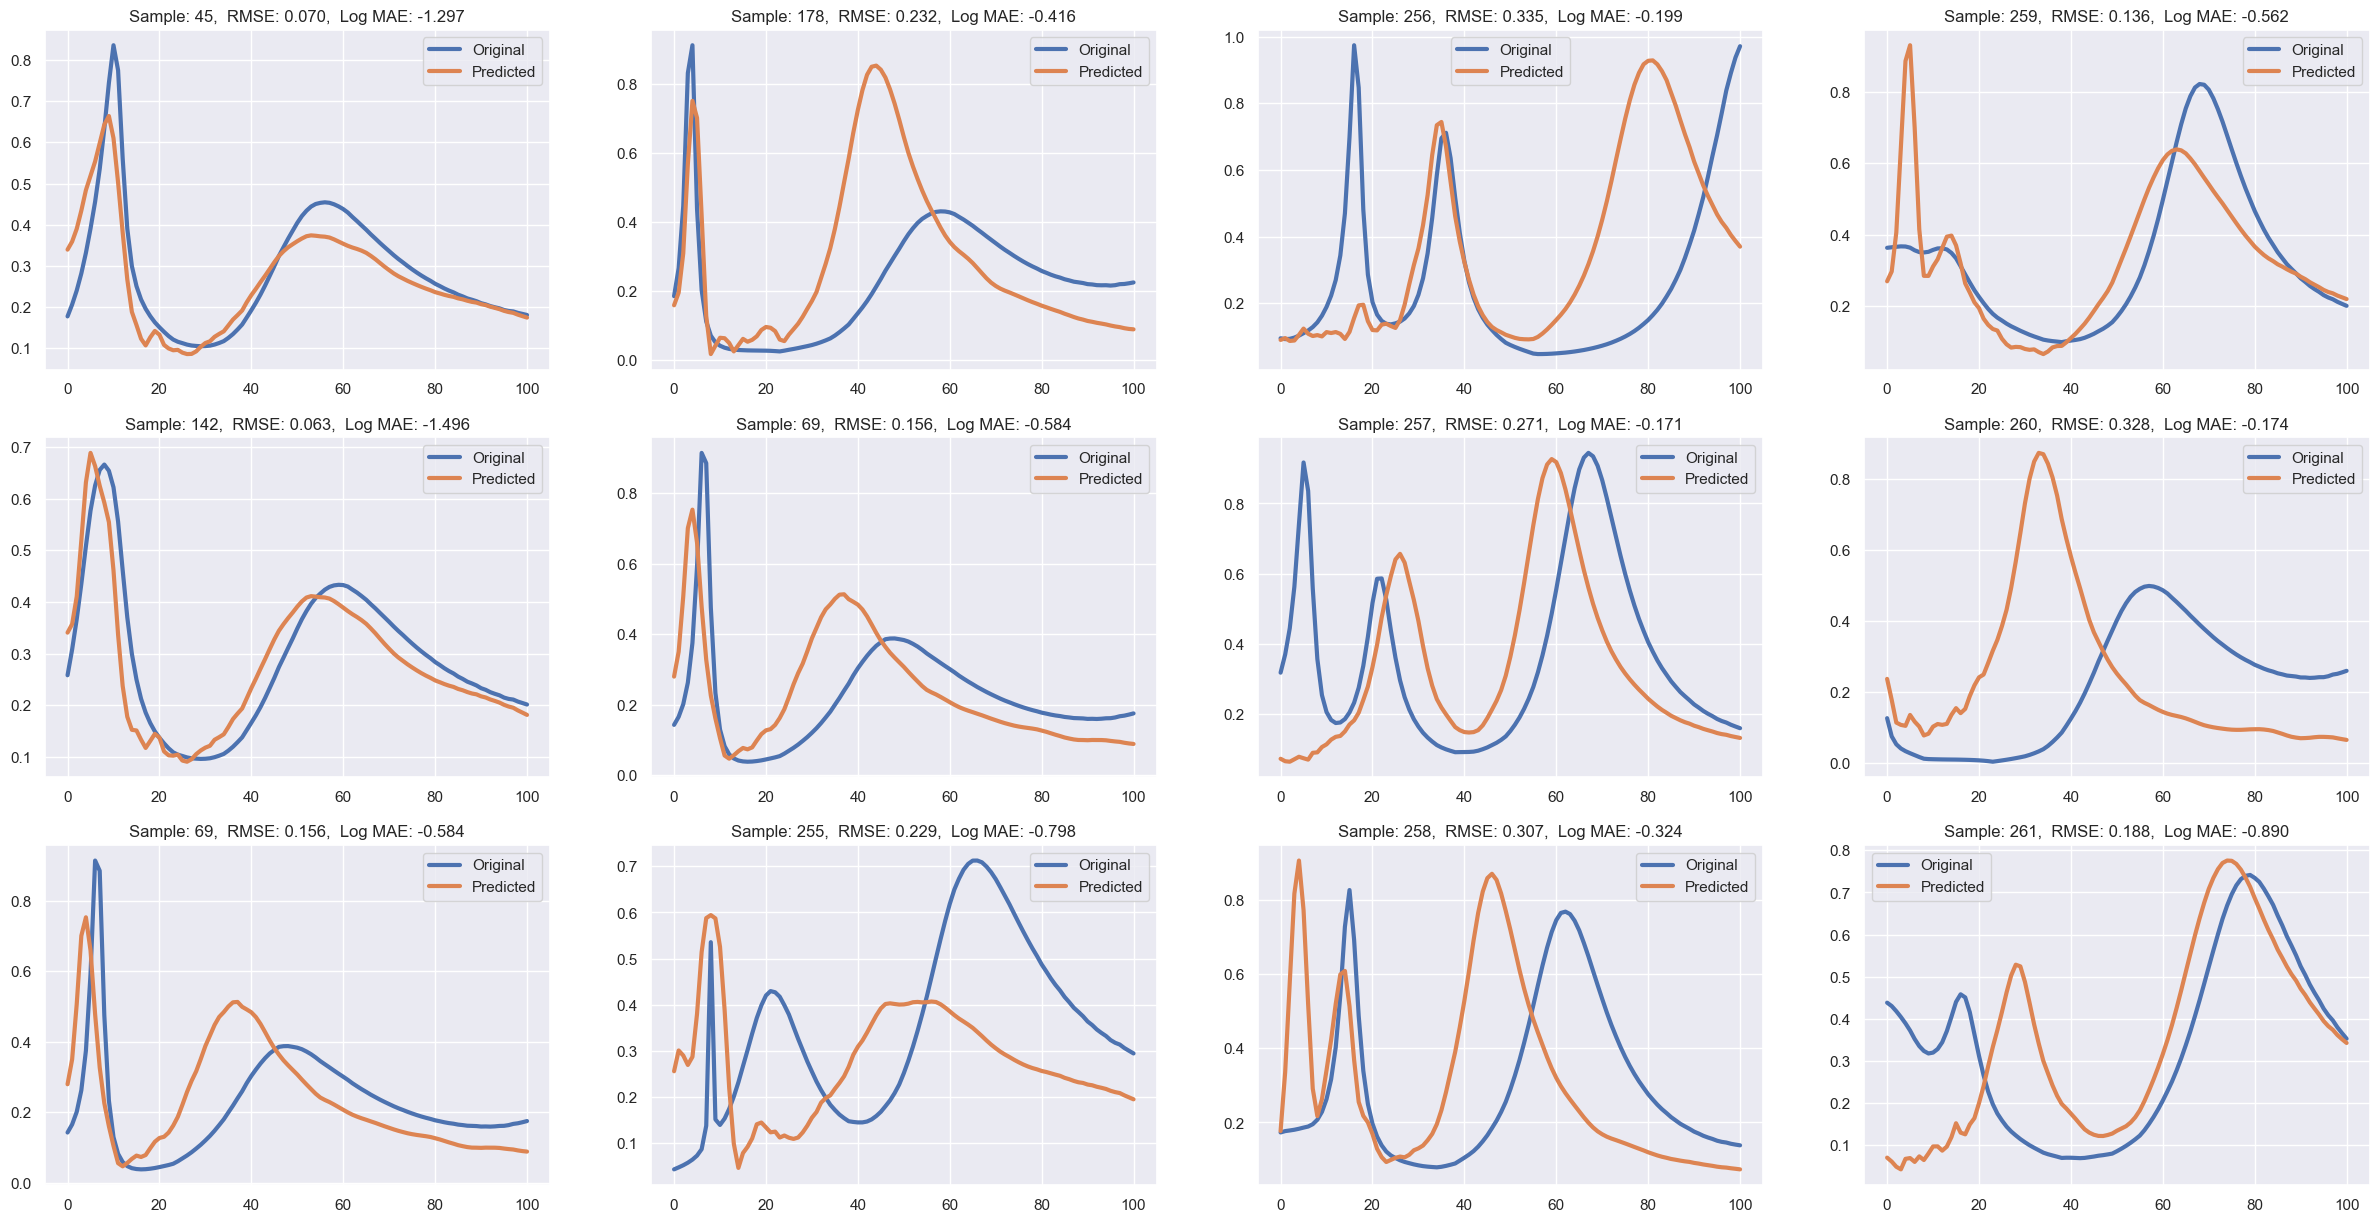

In [233]:
# Plot multiple samples using the same model
def plot_samples_ensamble(l, num):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains ten index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """
    
    MDN1 = torch.load('MDN1.pth')
    MDN2 = torch.load('MDN2.pth')
    MDN3 = torch.load('MDN3.pth')
    MDN4 = torch.load('MDN4.pth')
    MDN5 = torch.load('MDN5.pth')

    models = [MDN1, MDN2, MDN3, MDN4, MDN5]

    p, s, m, o = [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = ensemble_predict(models, i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])
    
    d5, d101 = [], []
    mod = torch.load('models/forward_models/cnn.pth')

    for i in range(len(m)):
        j = list(p[i]).index(max(list(p[i])))
        d5.append(list(m[i][j]))
        pre = mod(torch.from_numpy(m[i][j]).unsqueeze(0)).squeeze().tolist()
        d101.append(pre)
        
    ori = []
    for i in Data_test_scaled:
        ori.append(np.array(i))

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    def calc_log_mae(actual, predict):
        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return log_mae

    rmse = calc_rmse(np.array(ori), np.array(d101))
    log_mae = []
    for i in range(len(d101)):
        log_mae.append(calc_log_mae(ori[i], np.array(d101)[i]))
    print('Number of Distribution:', num, ', RMSE:', rmse, ', Mean Log MAE:', np.mean(log_mae))

    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    n = 0
    for i in range(4):
        for j in range(3):
            rmse = calc_rmse(ori[l[n]], np.array(d101)[l[n]])
            log_mae = calc_log_mae(ori[l[n]], np.array(d101)[l[n]])
            axs[j, i].set_title(f'Sample: {l[n]},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
            axs[j, i].plot(ori[l[n]], label='Original', linewidth=3)
            axs[j, i].plot(np.array(d101)[l[n]], label='Predicted', linewidth=3)
            axs[j, i].legend()
            n += 1

    plt.show()

l = [45, 142, 69, 178, 69, 255, 256, 257, 258, 259, 260, 261]
plot_samples_ensamble(l, 10)

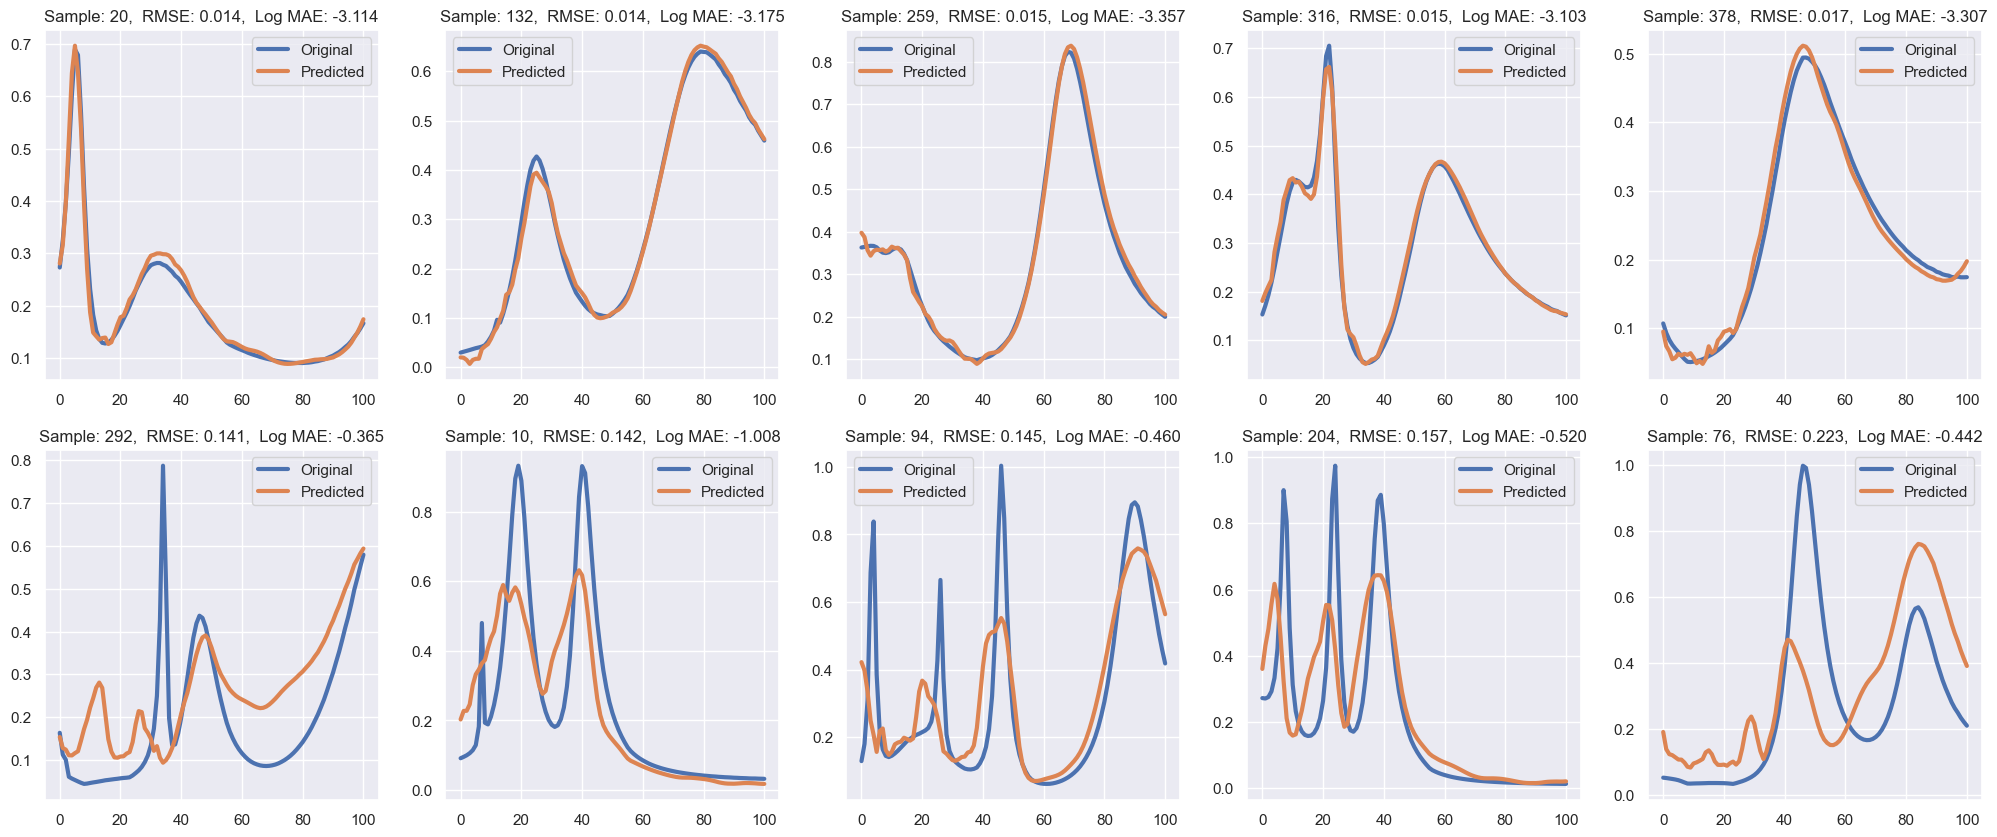

In [18]:
def plot_best_worst_predictions():
    # Rest of your existing code remains the same up to the calculation of `d101` and `ori`
 # Load models
    models = [torch.load(f'MDN{i}.pth') for i in range(1, 6)]

    # Load the forward model
    mod = torch.load('models/forward_models/cnn.pth')

    # Store final predictions from each model
    all_final_predictions = []

    # Generate and process predictions for each model
    for model in models:
        d5, d101 = [], []
        for batch_idx, (y, x) in enumerate(mdn_test_loader):
            for i in y:
                pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
                j = list(pi_variable.detach().numpy()[0]).index(max(list(pi_variable.detach().numpy()[0])))
                d5.append(list(mu_variable.detach().numpy()[0][j]))
                pre = mod(torch.from_numpy(mu_variable.detach().numpy()[0][j]).unsqueeze(0)).squeeze().tolist()
                d101.append(pre)
        all_final_predictions.append(d101)

    # Convert to numpy array for averaging
    all_final_predictions_np = np.array(all_final_predictions)

    # Average the final predictions
    d101 = np.mean(all_final_predictions_np, axis=0)

    ori = []
    for i in Data_test_scaled:
        ori.append(np.array(i))

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    def calc_log_mae(actual, predict):
        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return log_mae
    # Calculate RMSE or MAE for each prediction
    errors = []
    for i in range(len(d101)):
        error = calc_rmse(ori[i], np.array(d101)[i])  # or calc_log_mae
        errors.append((error, i))

    # Sort errors and select indices of best and worst predictions
    errors.sort()
    best_indices = [idx for _, idx in errors[:5]]
    worst_indices = [idx for _, idx in errors[-5:]]

    # Combine best and worst indices for plotting
    selected_indices = best_indices + worst_indices

    # Plotting code
    sns.set()
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))  # Adjust layout for 10 plots
    for n, idx in enumerate(selected_indices):
        i, j = divmod(n, 5)  # Adjust grid positions
        rmse = calc_rmse(ori[idx], np.array(d101)[idx])
        log_mae = calc_log_mae(ori[idx], np.array(d101)[idx])
        axs[i, j].set_title(f'Sample: {idx},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
        axs[i, j].plot(ori[idx], label='Original', linewidth=3)
        axs[i, j].plot(np.array(d101)[idx], label='Predicted', linewidth=3)
        axs[i, j].legend()

    plt.show()

# Example usage
plot_best_worst_predictions()


Number of Distribution: 10 , RMSE: 0.060037809369671916 , Mean Log MAE: -1.5645335273524166


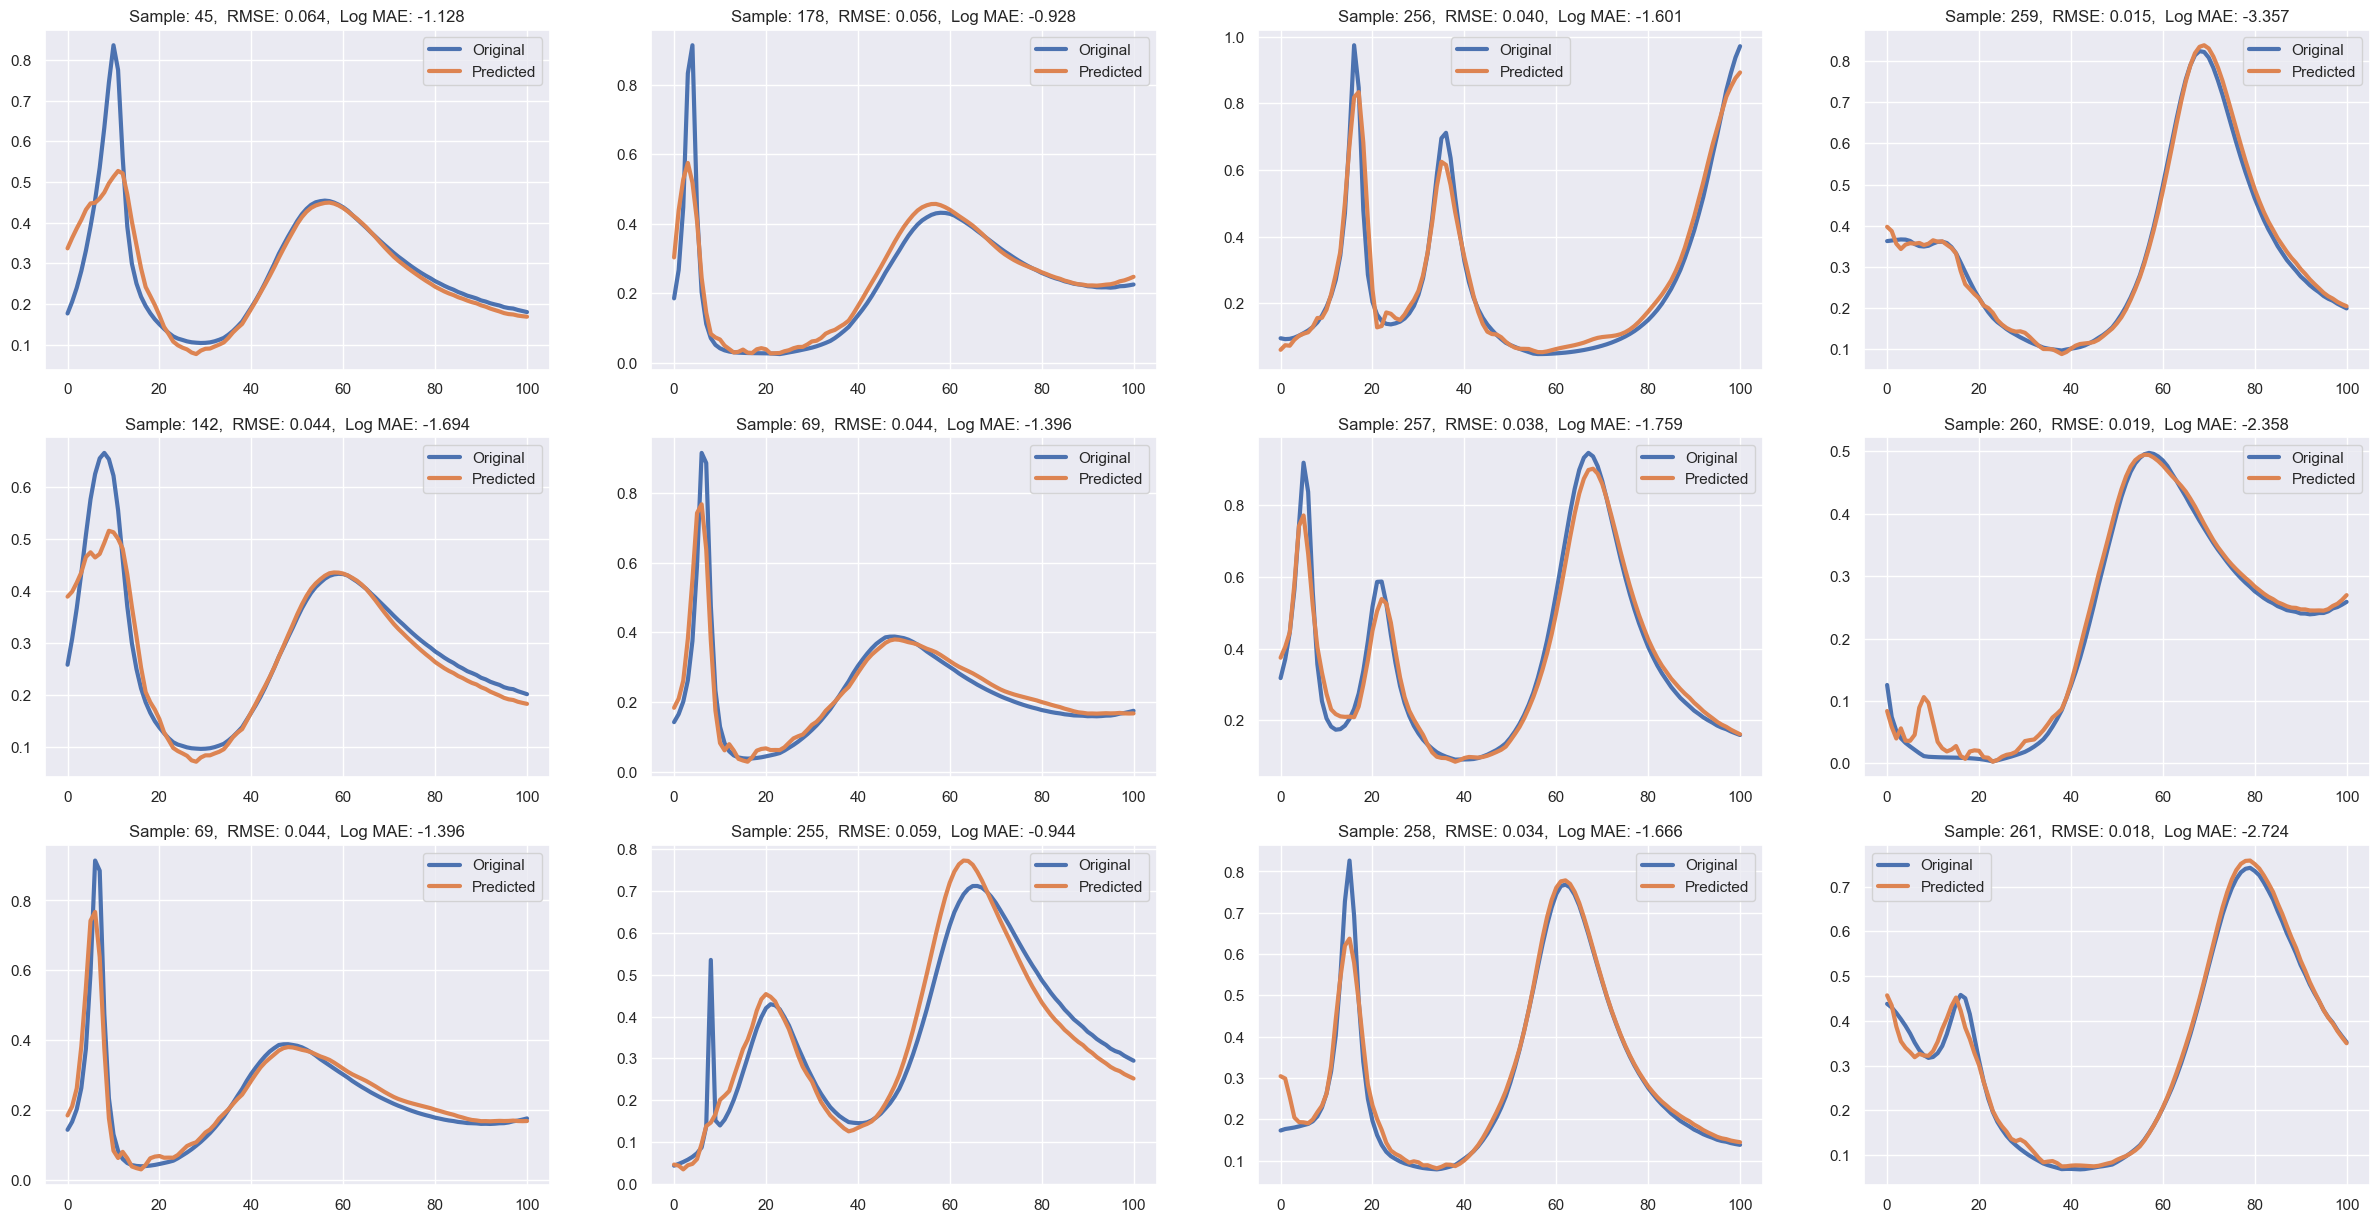

In [17]:
def plot_samples_ensamble(l, num):    
    # Load models
    models = [torch.load(f'MDN{i}.pth') for i in range(1, 6)]

    # Load the forward model
    mod = torch.load('models/forward_models/cnn.pth')

    # Store final predictions from each model
    all_final_predictions = []

    # Generate and process predictions for each model
    for model in models:
        d5, d101 = [], []
        for batch_idx, (y, x) in enumerate(mdn_test_loader):
            for i in y:
                pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
                j = list(pi_variable.detach().numpy()[0]).index(max(list(pi_variable.detach().numpy()[0])))
                d5.append(list(mu_variable.detach().numpy()[0][j]))
                pre = mod(torch.from_numpy(mu_variable.detach().numpy()[0][j]).unsqueeze(0)).squeeze().tolist()
                d101.append(pre)
        all_final_predictions.append(d101)

    # Convert to numpy array for averaging
    all_final_predictions_np = np.array(all_final_predictions)

    # Average the final predictions
    d101 = np.mean(all_final_predictions_np, axis=0)

    ori = []
    for i in Data_test_scaled:
        ori.append(np.array(i))

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    def calc_log_mae(actual, predict):
        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return log_mae

    rmse = calc_rmse(np.array(ori), np.array(d101))
    log_mae = []
    for i in range(len(d101)):
        log_mae.append(calc_log_mae(ori[i], np.array(d101)[i]))
    print('Number of Distribution:', num, ', RMSE:', rmse, ', Mean Log MAE:', np.mean(log_mae))

    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    n = 0
    for i in range(4):
        for j in range(3):
            rmse = calc_rmse(ori[l[n]], np.array(d101)[l[n]])
            log_mae = calc_log_mae(ori[l[n]], np.array(d101)[l[n]])
            axs[j, i].set_title(f'Sample: {l[n]},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
            axs[j, i].plot(ori[l[n]], label='Original', linewidth=3)
            axs[j, i].plot(np.array(d101)[l[n]], label='Predicted', linewidth=3)
            axs[j, i].legend()
            n += 1

    plt.show()

l = [45, 142, 69, 178, 69, 255, 256, 257, 258, 259, 260, 261]
plot_samples_ensamble(l, 10)


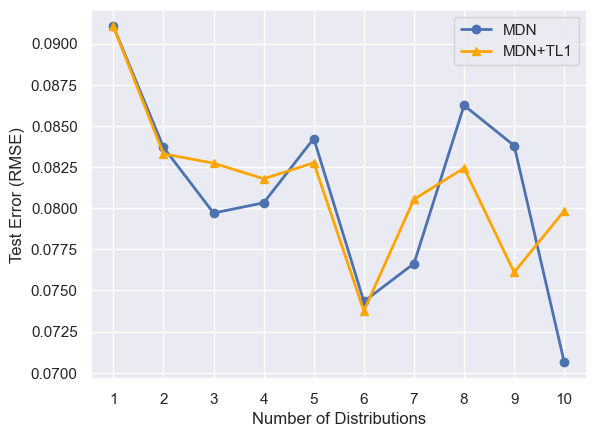

In [15]:
# Plot test rmse
def test_rmse(path, loader, dataset):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Folder path of models used for test
    - param2: Test data loader (can be found in the block of import data)
    - param3: Test spectrum dataset (can be found in the block of import data)

    Returns:
    The function returns 2 lists that contains test error (rmse and mse) of each model
    """

    e1, e2 = [], []
    for a in range(1, 11):
        MDN(num_gaussians=a)
        model = torch.load(path+str(a)+'.pth')
        
        p, s, m, o = [], [], [], []
        for batch_idx, (y, x) in enumerate(loader):
            for i in y:
                pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
                p.append(pi_variable.detach().numpy()[0])
                s.append(sigma_variable.detach().numpy()[0])
                m.append(mu_variable.detach().numpy()[0])

        d5, d101 = [], []
        mod = torch.load('models/forward_models/cnn.pth')
        for i in range(len(m)):
            j = list(p[i]).index(max(list(p[i])))
            d5.append(list(m[i][j]))
            pre = mod(torch.from_numpy(m[i][j]).unsqueeze(0)).squeeze().tolist()
            d101.append(pre)
            
        ori = dataset

        # calculate rmse & mse  
        squared_diff = (np.array(ori) - np.array(d101)) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        e1.append(rmse)
        e2.append(mse)
        #print('MSE:', rmse)

    return e1, e2

MDN_rmse, MDN_mse = test_rmse('models/AE_MDN/', mdn_test_loader, Data_test_scaled)
MDN_tl_rmse, MDN_tl_mse = test_rmse('models/AE_MDN_TL_1/', mdn_test_loader, Data_test_scaled)
ax = plt.figure().gca()
x_values = list(np.arange(1, 11))
ax.plot(MDN_rmse, 'o-', linewidth=2, color='b', label='MDN')
ax.plot(MDN_tl_rmse, '^-', linewidth=2, color='orange', label='MDN+TL1')
ax.set_ylabel('Test Error (RMSE)')
ax.set_xlabel('Number of Distributions')
ax.set_xticks(np.arange(len(x_values)))
ax.set_xticklabels(x_values)
ax.legend()
plt.show()